In [2]:
import numpy as np
import os
import sys
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, get_peft_model_state_dict
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT
import seaborn as sns
from matplotlib import pyplot as plt
import datasets
import glob

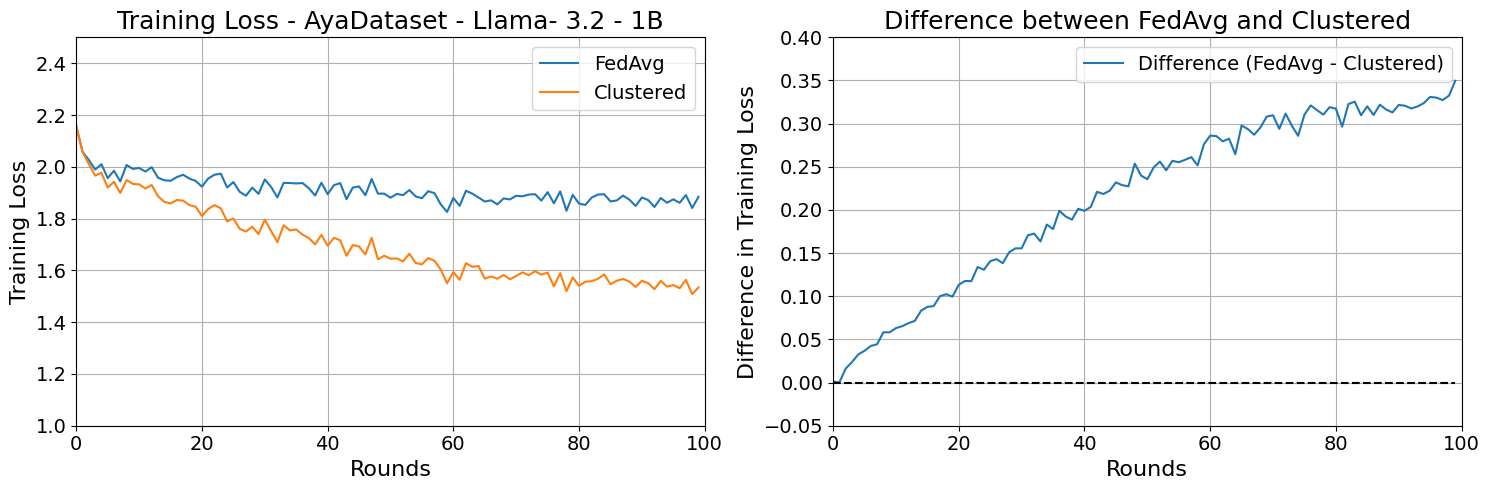

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path = 'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = 'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg', ax=ax[0])
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered', ax=ax[0])

ax[0].set_title('Training Loss - AyaDataset - Llama- 3.2 - 1B', fontsize=18)
ax[0].set_xlabel('Rounds', fontsize=16)
ax[0].set_ylabel('Training Loss', fontsize=16)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(1, 2.5)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].grid(True)
ax[0].legend(fontsize=14)

# Difference between fedavg and clustered
diff = [losses[i] - losses2[i] for i in range(len(losses))]

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)', ax=ax[1])
sns.lineplot(x=range(len(diff)), y=[0]*len(diff), ax=ax[1], color='k', linestyle='--')
ax[1].set_title('Difference between FedAvg and Clustered', fontsize=18)
ax[1].set_xlabel('Rounds', fontsize=16)
ax[1].set_ylabel('Difference in Training Loss', fontsize=16)
ax[1].set_xlim(0, 100)
ax[1].set_ylim(-0.05, 0.4)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].grid(True)
ax[1].legend(fontsize=14)

plt.tight_layout()
ax[0].figure.savefig('figs/loss_1B_ax0.pdf', dpi=900)


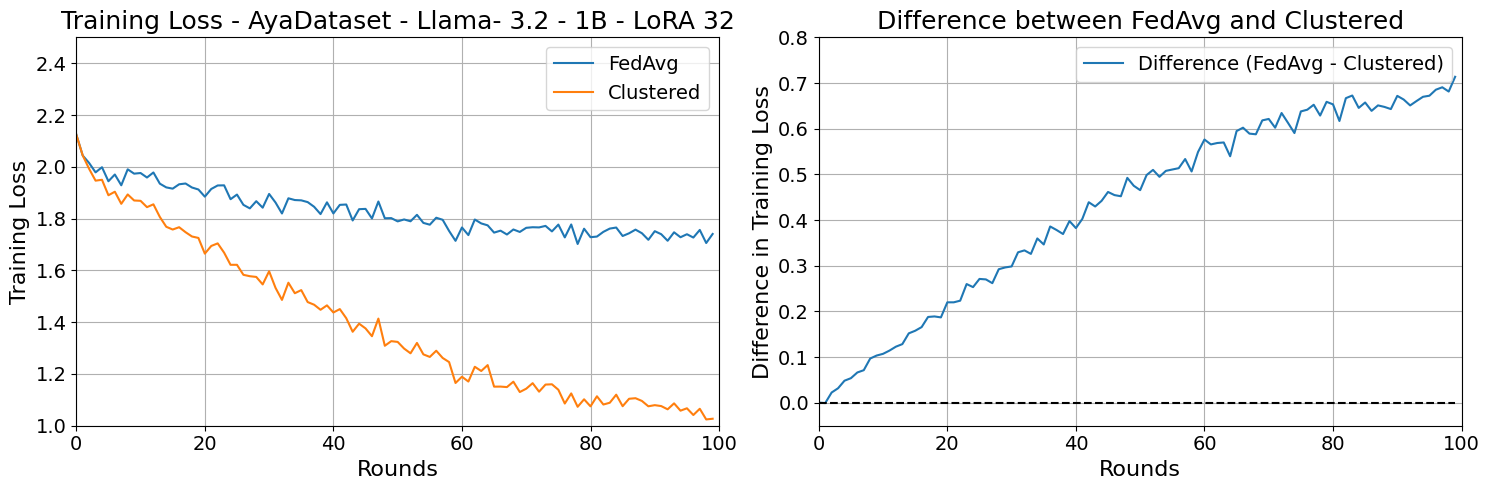

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path = 'output_aya/bracis/Llama-3.2-1B/fedavg_lora32_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r32a64_20250425132103/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = 'output_aya/bracis/Llama-3.2-1B/clustered_lora32_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r32a64_20250425132001/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg', ax=ax[0])
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered', ax=ax[0])

ax[0].set_title('Training Loss - AyaDataset - Llama- 3.2 - 1B - LoRA 32', fontsize=18)
ax[0].set_xlabel('Rounds', fontsize=16)
ax[0].set_ylabel('Training Loss', fontsize=16)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(1, 2.5)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].grid(True)
ax[0].legend(fontsize=14)

# Difference between fedavg and clustered
diff = [losses[i] - losses2[i] for i in range(len(losses))]

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)', ax=ax[1])
sns.lineplot(x=range(len(diff)), y=[0]*len(diff), ax=ax[1], color='k', linestyle='--')
ax[1].set_title('Difference between FedAvg and Clustered', fontsize=18)
ax[1].set_xlabel('Rounds', fontsize=16)
ax[1].set_ylabel('Difference in Training Loss', fontsize=16)
ax[1].set_xlim(0, 100)
ax[1].set_ylim(-0.05, 0.8)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].grid(True)
ax[1].legend(fontsize=14)

plt.tight_layout()
ax[0].figure.savefig('figs/loss_1B_ax0.pdf', dpi=900)


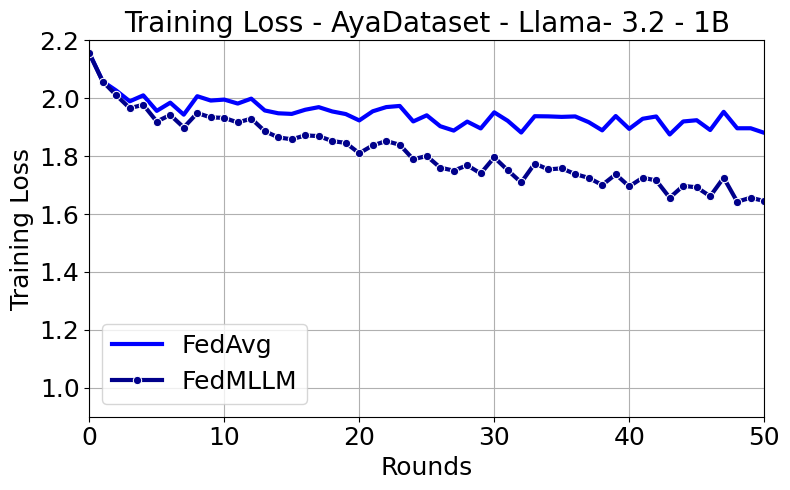

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

path = 'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = 'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg', ax=ax, color='blue', linewidth=3)
sns.lineplot(x=range(len(losses2)), y=losses2, label='FedMLLM', ax=ax, color='darkblue', marker='o', linewidth=3)

ax.set_title('Training Loss - AyaDataset - Llama- 3.2 - 1B', fontsize=20)
ax.set_xlabel('Rounds', fontsize=18)
ax.set_ylabel('Training Loss', fontsize=18)
ax.set_xlim(0, 50)
ax.set_ylim(0.9, 2.2)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(True)
ax.legend(fontsize=18)

plt.tight_layout()
ax.figure.savefig('figs/loss_1B.pdf', dpi=900)

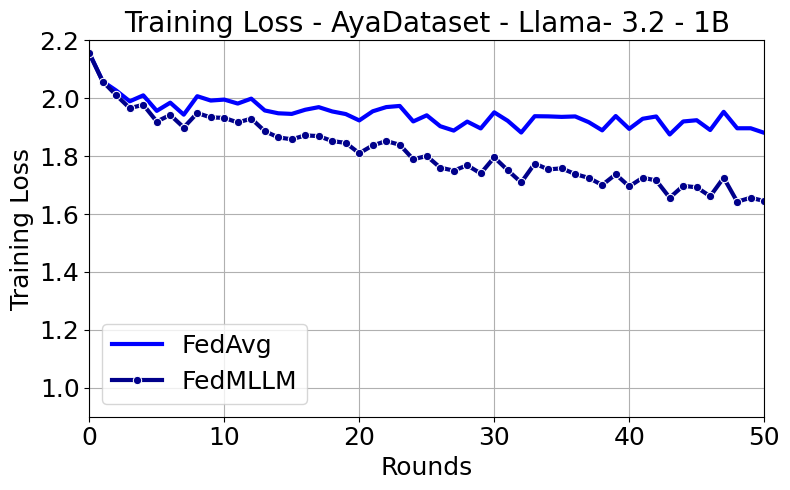

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

path = 'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = 'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

path = 'output_aya/bracis/Llama-3.2-1B/clustered_mais_um_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250422144727/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses3 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses3.append(loss)

path = 'output_aya/bracis/Llama-3.2-1B/clustered_menos_um_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250422144813/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses4 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses4.append(loss)

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg', ax=ax, color='blue', linewidth=3)
sns.lineplot(x=range(len(losses2)), y=losses2, label='FedMLLM', ax=ax, color='darkblue', marker='o', linewidth=3)
#sns.lineplot(x=range(len(losses3)), y=losses3, label='FedMLLM (+1)', ax=ax, color='red', linewidth=3)
#sns.lineplot(x=range(len(losses4)), y=losses4, label='FedMLLM (-1)', ax=ax, color='k', linewidth=3)

ax.set_title('Training Loss - AyaDataset - Llama- 3.2 - 1B', fontsize=20)
ax.set_xlabel('Rounds', fontsize=18)
ax.set_ylabel('Training Loss', fontsize=18)
ax.set_xlim(0, 50)
ax.set_ylim(0.9, 2.2)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(True)
ax.legend(fontsize=18)

plt.tight_layout()
ax.figure.savefig('figs/loss_1B.pdf', dpi=900)

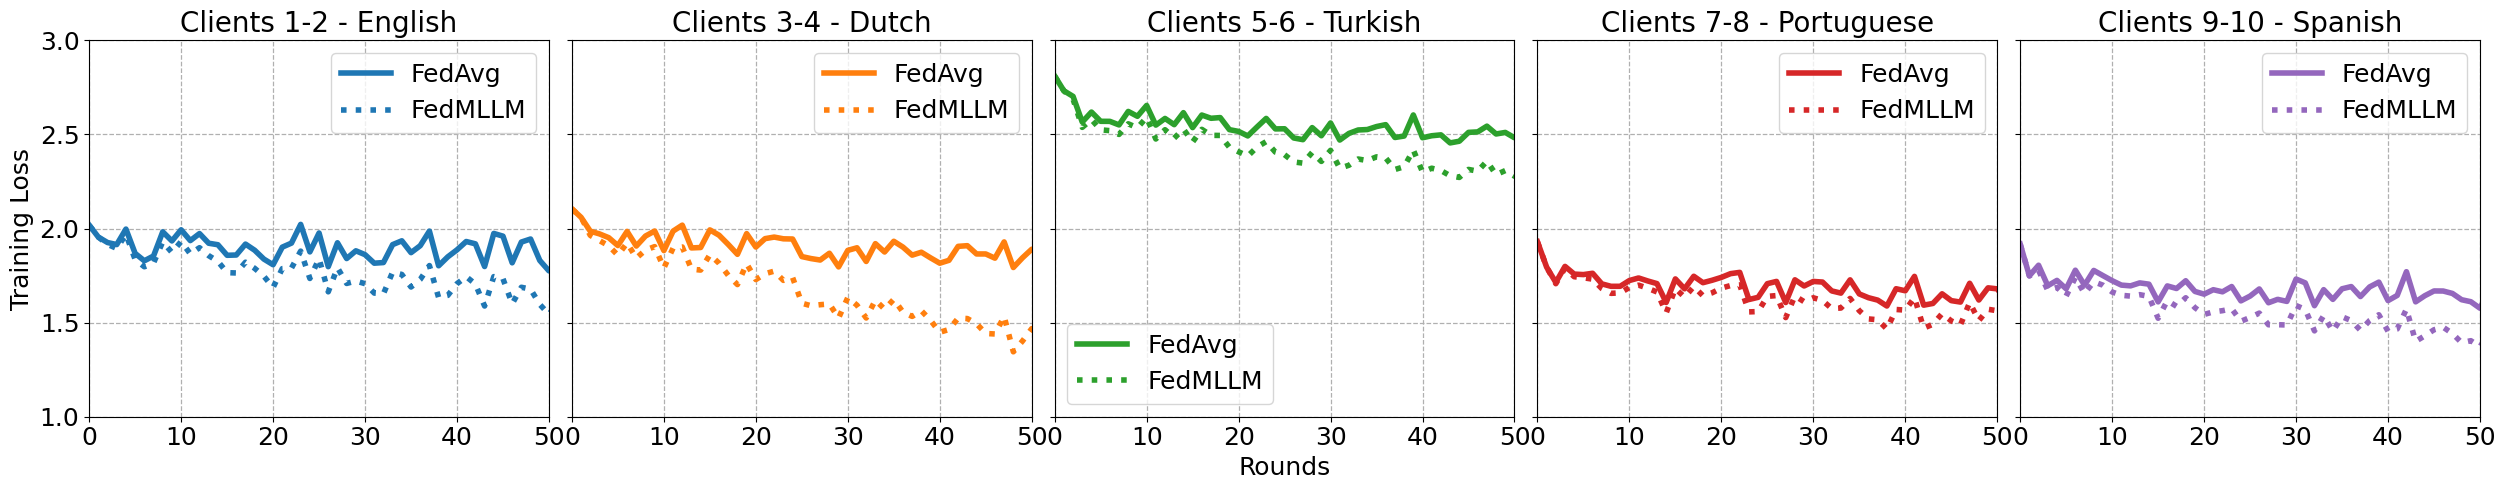

In [7]:
colors = sns.color_palette("tab10", 5)

# Load AYA data for FedAvg and Clustered solutions
fedavg_path = 'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/training_loss.npy'
data_fedavg = np.load(fedavg_path, allow_pickle=True)

clustered_path = 'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606/training_loss.npy'
data_clustered = np.load(clustered_path, allow_pickle=True)

rounds = np.arange(data_fedavg.shape[1])

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
languages = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']
for i, ax in enumerate(axes):
    start = i * 2
    fedavg_subset = data_fedavg[start:start+2, :]
    clustered_subset = data_clustered[start:start+2, :]
    fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
    clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
    
    # Plot FedAvg (solid) and Clustered (dotted) in the same subplot
    sns.lineplot(x=rounds, y=fedavg_mean, ax=ax, label=f'FedAvg',
                 color=colors[i], linestyle='solid', linewidth=4)
    sns.lineplot(x=rounds, y=clustered_mean, ax=ax, label=f'FedMLLM',
                 color=colors[i], linestyle='dotted', linewidth=4)
    
    ax.set_title(f'Clients {start+1}-{start+2} - {languages[i]}', fontsize=20)
    ax.set_xlim(0, 50)

    if i == 0:
        ax.set_ylabel('Training Loss', fontsize=18)
    
    else:
        #remove y ticks
        ax.set_ylabel('', fontsize=1)
        ax.set_yticklabels([])
    if i == 2:
        ax.set_xlabel('Rounds', fontsize=18)

    ax.set_ylim(1, 3.)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(True, linestyle='--', linewidth=0.9)
    ax.legend(fontsize=18)

plt.tight_layout()

plt.savefig('figs/loss_1B_per_task.pdf', dpi=900)
plt.show()


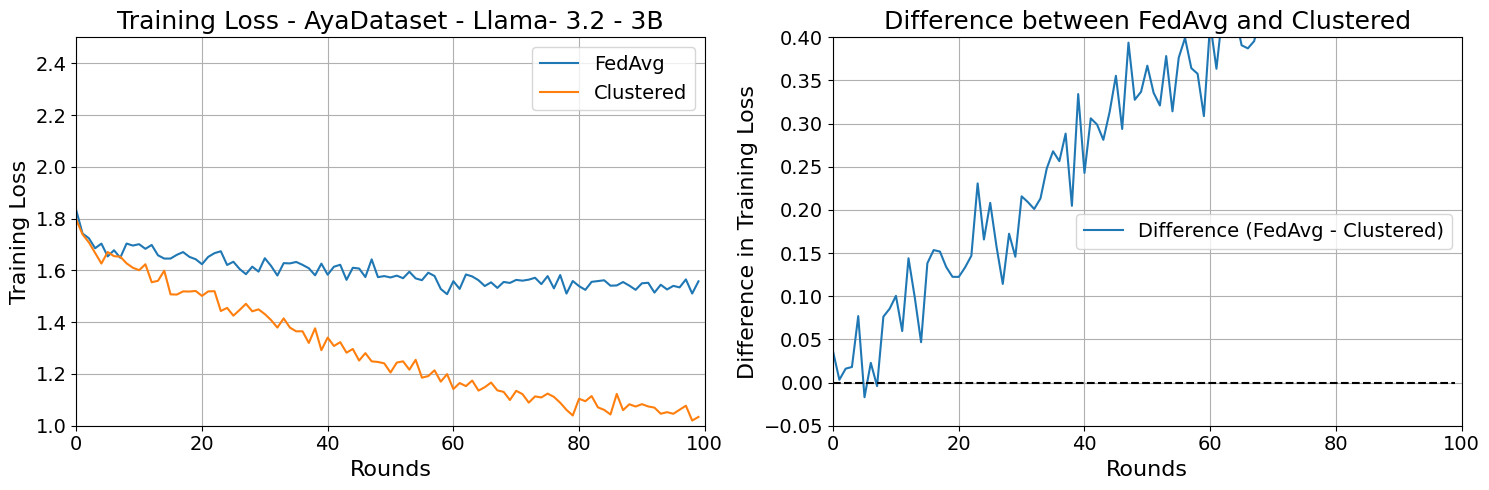

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

path = 'output_aya/bracis/Llama-3.2-3B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418184753/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = 'output_aya/bracis/Llama-3.2-3B/clustered_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250420191606/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

path = 'output_aya/bracis/Llama-3.2-3B/FD_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418184234/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses3 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses3.append(loss)

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg', ax=ax[0])
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered', ax=ax[0])

ax[0].set_title('Training Loss - AyaDataset - Llama- 3.2 - 3B', fontsize=18)
ax[0].set_xlabel('Rounds', fontsize=16)
ax[0].set_ylabel('Training Loss', fontsize=16)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(1, 2.5)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].grid(True)
ax[0].legend(fontsize=14)

# Difference between fedavg and clustered
diff = []
for i in range(len(losses2)):
    diff.append(losses[i] - losses2[i])

sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)', ax=ax[1])
sns.lineplot(x=range(len(diff)), y=[0]*len(diff), ax=ax[1], color='k', linestyle='--')
ax[1].set_title('Difference between FedAvg and Clustered', fontsize=18)
ax[1].set_xlabel('Rounds', fontsize=16)
ax[1].set_ylabel('Difference in Training Loss', fontsize=16)
ax[1].set_xlim(0, 100)
ax[1].set_ylim(-0.05, 0.4)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].grid(True)
ax[1].legend(fontsize=14)

plt.tight_layout()
ax[0].figure.savefig('figs/loss_3B_ax0.pdf', dpi=900)

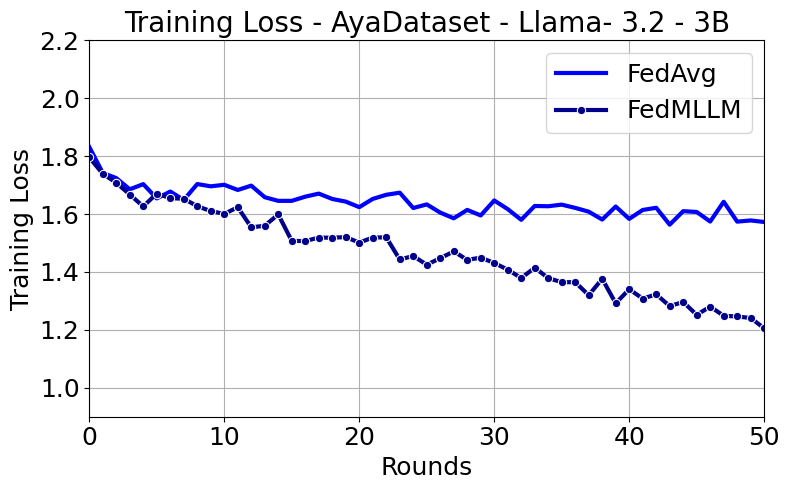

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))

path = 'output_aya/bracis/Llama-3.2-3B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418184753/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = 'output_aya/bracis/Llama-3.2-3B/clustered_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250420191606/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg', ax=ax, color='blue', linewidth=3)
sns.lineplot(x=range(len(losses2)), y=losses2, label='FedMLLM', ax=ax, color='darkblue', marker='o', linewidth=3)

ax.set_title('Training Loss - AyaDataset - Llama- 3.2 - 3B', fontsize=20)
ax.set_xlabel('Rounds', fontsize=18)
ax.set_ylabel('Training Loss', fontsize=18)
ax.set_xlim(0, 50)
ax.set_ylim(0.9, 2.2)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(True)
ax.legend(fontsize=18)

plt.tight_layout()
ax.figure.savefig('figs/loss_3B.pdf', dpi=900)

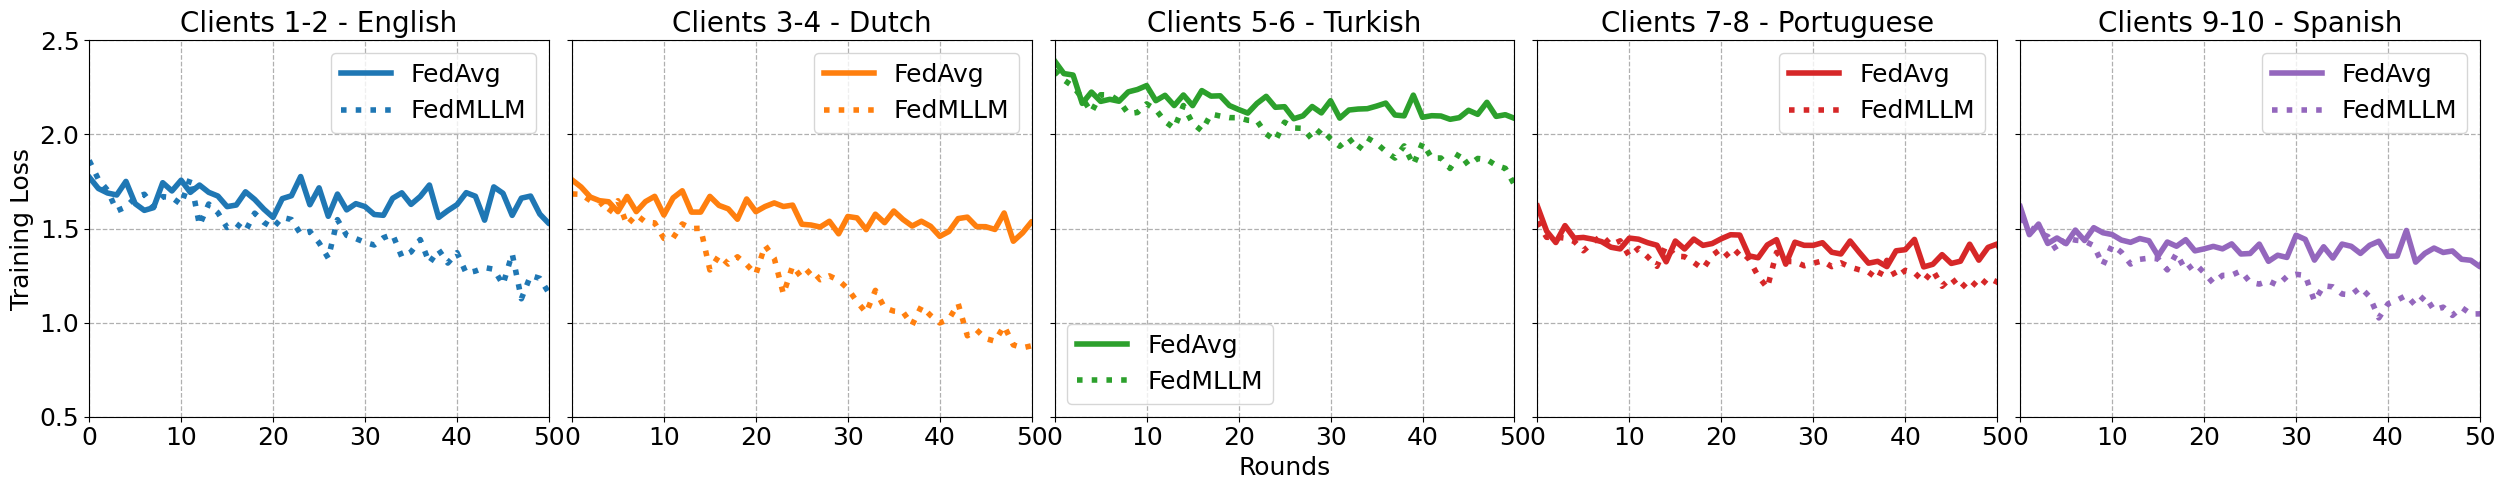

In [10]:
colors = sns.color_palette("tab10", 5)

# Load AYA data for FedAvg and Clustered solutions
fedavg_path = 'output_aya/bracis/Llama-3.2-3B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418184753/training_loss.npy'
data_fedavg = np.load(fedavg_path, allow_pickle=True)

clustered_path = 'output_aya/bracis/Llama-3.2-3B/clustered_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250420191606/training_loss.npy'
data_clustered = np.load(clustered_path, allow_pickle=True)

rounds = np.arange(data_fedavg.shape[1])

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
languages = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']
for i, ax in enumerate(axes):
    start = i * 2
    fedavg_subset = data_fedavg[start:start+2, :]
    clustered_subset = data_clustered[start:start+2, :]
    fedavg_mean = np.nanmean(np.where(fedavg_subset != -1, fedavg_subset, np.nan), axis=0)
    clustered_mean = np.nanmean(np.where(clustered_subset != -1, clustered_subset, np.nan), axis=0)
    
    # Plot FedAvg (solid) and Clustered (dotted) in the same subplot
    sns.lineplot(x=rounds, y=fedavg_mean, ax=ax, label=f'FedAvg',
                 color=colors[i], linestyle='solid', linewidth=4)
    sns.lineplot(x=rounds, y=clustered_mean, ax=ax, label=f'FedMLLM',
                 color=colors[i], linestyle='dotted', linewidth=4)
    
    ax.set_title(f'Clients {start+1}-{start+2} - {languages[i]}', fontsize=20)

    ax.set_xlim(0, 50)

    if i == 0:
        ax.set_ylabel('Training Loss', fontsize=18)
    
    else:
        #remove y ticks
        ax.set_ylabel('', fontsize=1)
        ax.set_yticklabels([])
    if i == 2:
        ax.set_xlabel('Rounds', fontsize=18)

    ax.set_ylim(0.5, 2.5)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.grid(True, linestyle='--', linewidth=0.9)
    ax.legend(fontsize=18)

plt.tight_layout()
plt.savefig('figs/loss_3B_per_task.pdf', dpi=900)
plt.show()


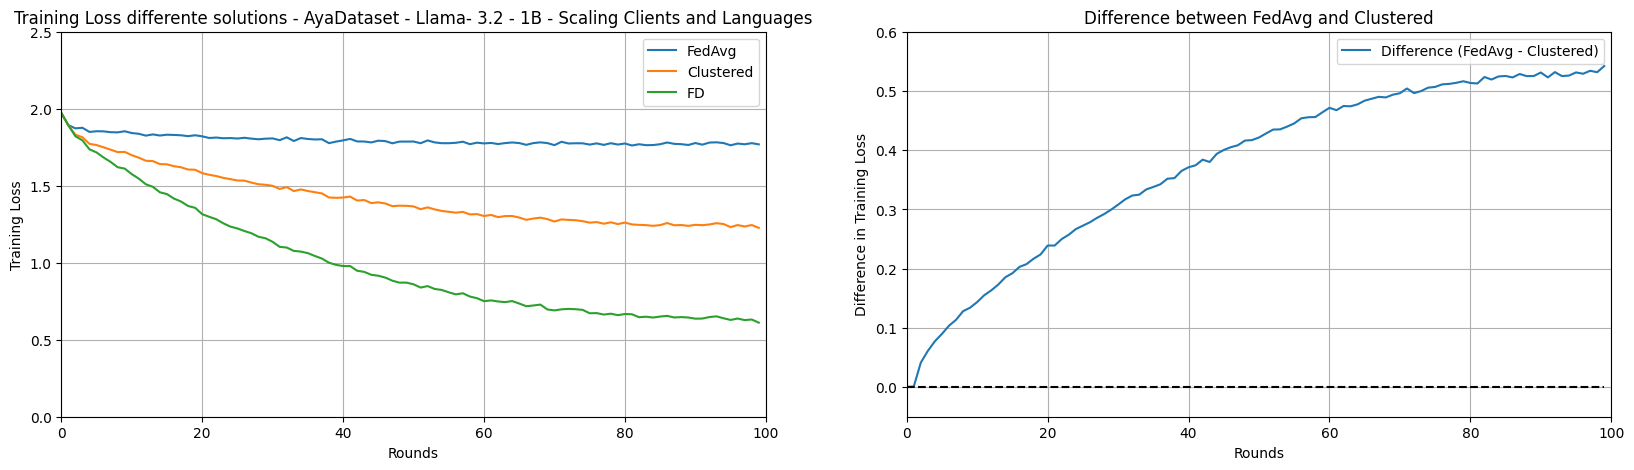

<Figure size 1000x500 with 0 Axes>

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

path = 'output_aya/bracis/Llama-3.2-1B/fedavg_scaling2_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250422143202/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses.append(loss)

path = 'output_aya/bracis/Llama-3.2-1B/clustered_scaling2_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250422142642/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses2 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses2.append(loss)

path = 'output_aya/bracis/Llama-3.2-1B/FD_scaling2_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250422143744/training_loss.npy'
data = np.load(path, allow_pickle=True)

losses3 = []
data = data.T
for r in range(len(data)):
    loss = np.where(data[r] != -1, data[r], np.nan)
    loss = loss[~np.isnan(loss)]
    loss = loss.mean()
    losses3.append(loss)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(len(losses)), y=losses, label='FedAvg', ax=ax[0])
sns.lineplot(x=range(len(losses2)), y=losses2, label='Clustered', ax=ax[0])
sns.lineplot(x=range(len(losses3)), y=losses3, label='FD', ax=ax[0])

# Set overall title
ax[0].set_title('Training Loss differente solutions - AyaDataset - Llama- 3.2 - 1B - Scaling Clients and Languages')
ax[0].set_xlabel('Rounds')
ax[0].set_ylabel('Training Loss')
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 2.5)
ax[0].grid(True)
ax[0].legend()

#difference between fedavg and clustered
diff = []
for i in range(len(losses)):
    diff.append(losses[i] - losses2[i])

# Plot the difference
sns.lineplot(x=range(len(diff)), y=diff, label='Difference (FedAvg - Clustered)', ax=ax[1])
sns.lineplot(x=range(len(diff)), y=[0]*len(diff), ax=ax[1], color='k', linestyle='--')
ax[1].set_title('Difference between FedAvg and Clustered')
ax[1].set_xlabel('Rounds')
ax[1].set_ylabel('Difference in Training Loss')
ax[1].set_xlim(0, 100)
ax[1].set_ylim(-0.05, 0.6)
ax[1].grid(True)
ax[1].legend()
plt.tight_layout()

Text(0.5, 1.0, 'Similarity Matrix B')

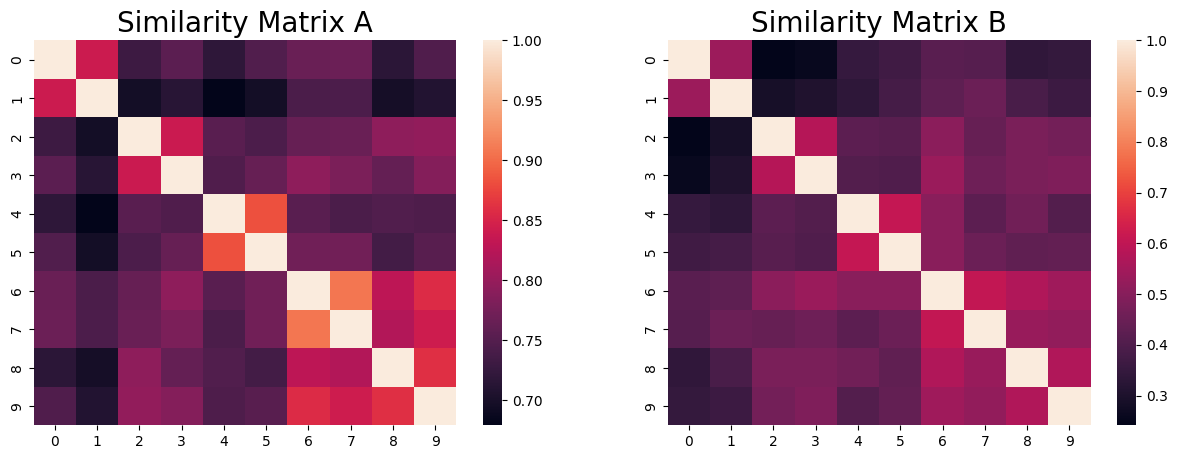

In [12]:
simA = 'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606/similarity_A_round1.npy'
simB = 'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606/similarity_B_round1.npy'

#subpplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Load the similarity matrices
similarity_A = np.load(simA)
similarity_B = np.load(simB)

sns.heatmap(similarity_A, ax=axes[0], cbar=True)
axes[0].set_title('Similarity Matrix A', fontsize=20)
sns.heatmap(similarity_B, ax=axes[1], cbar=True)
axes[1].set_title('Similarity Matrix B', fontsize=20)


Text(0.5, 1.0, 'Similarity Matrix B')

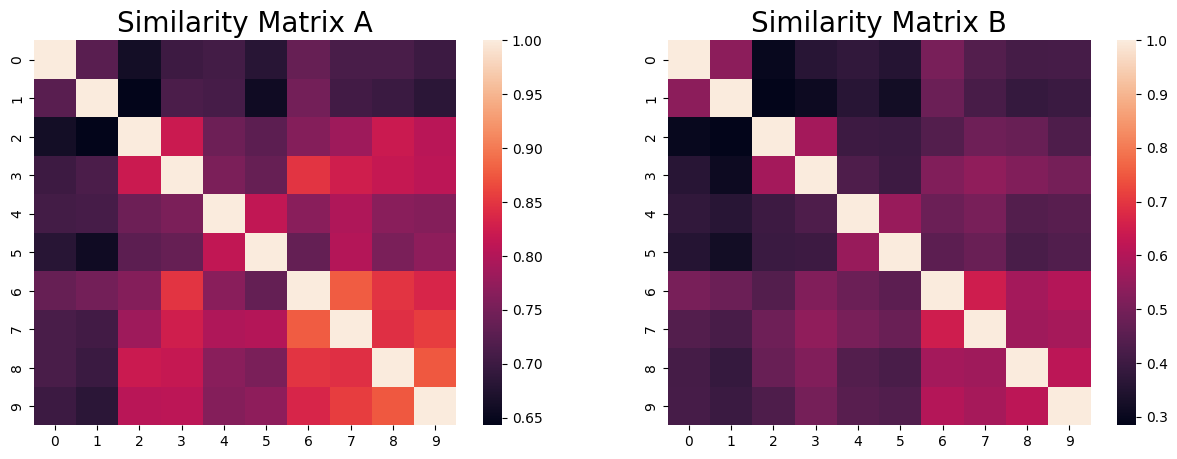

In [13]:
simA = 'output_aya/bracis/Llama-3.2-3B/clustered_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250420191606/similarity_A_round1.npy'
simB = 'output_aya/bracis/Llama-3.2-3B/clustered_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250420191606/similarity_B_round1.npy'

#subpplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Load the similarity matrices
similarity_A = np.load(simA)
similarity_B = np.load(simB)

sns.heatmap(similarity_A, ax=axes[0], cbar=True)
axes[0].set_title('Similarity Matrix A', fontsize=20)
sns.heatmap(similarity_B, ax=axes[1], cbar=True)
axes[1].set_title('Similarity Matrix B', fontsize=20)


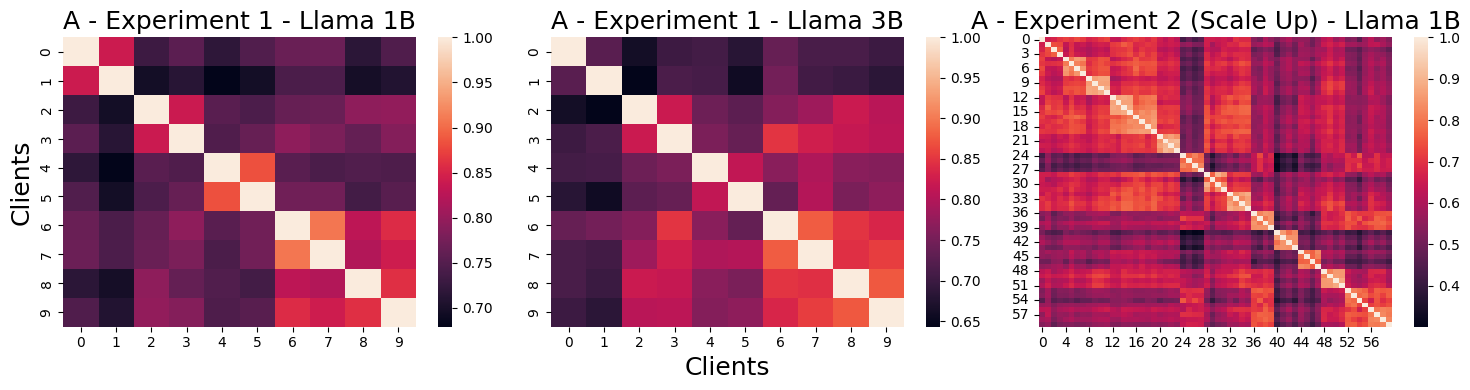

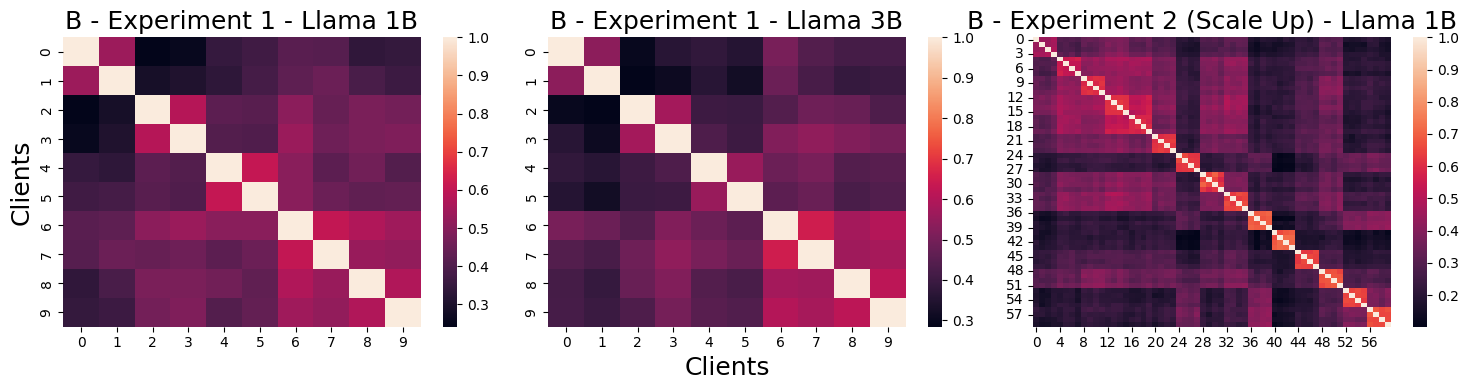

In [14]:
simA_1B = 'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606/similarity_A_round1.npy'
simA_3B = 'output_aya/bracis/Llama-3.2-3B/clustered_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250420191606/similarity_A_round1.npy'
simA_scaling = 'output_aya/bracis/Llama-3.2-1B/clustered_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419164225/similarity_A_round1.npy'

# Load the similarity matrices
similarity_A_1B = np.load(simA_1B)
similarity_A_3B = np.load(simA_3B)
similarity_A_scaling = np.load(simA_scaling)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


sns.heatmap(similarity_A_1B, ax=axes[0], cbar=True)
axes[0].set_title('A - Experiment 1 - Llama 1B', fontsize=18)
axes[0].set_ylabel('Clients', fontsize=18)
sns.heatmap(similarity_A_3B, ax=axes[1], cbar=True)
axes[1].set_xlabel('Clients', fontsize=18)

axes[1].set_title('A - Experiment 1 - Llama 3B', fontsize=18)
sns.heatmap(similarity_A_scaling, ax=axes[2], cbar=True)
axes[2].set_title('A - Experiment 2 (Scale Up) - Llama 1B', fontsize=18)

plt.tight_layout()
plt.savefig('figs/similarity_A.pdf', dpi=900)
plt.show()

simB_1B = 'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606/similarity_B_round1.npy'
simB_3B = 'output_aya/bracis/Llama-3.2-3B/clustered_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250420191606/similarity_B_round1.npy'
simB_scaling = 'output_aya/bracis/Llama-3.2-1B/clustered_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419164225/similarity_B_round1.npy'
# Load the similarity matrices

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


similarity_B_1B = np.load(simB_1B)
similarity_B_3B = np.load(simB_3B)
similarity_B_scaling = np.load(simB_scaling)

sns.heatmap(similarity_B_1B, ax=axes[0], cbar=True)
axes[0].set_title('B - Experiment 1 - Llama 1B', fontsize=18)
axes[0].set_ylabel('Clients', fontsize=18)
sns.heatmap(similarity_B_3B, ax=axes[1], cbar=True)
axes[1].set_xlabel('Clients', fontsize=18)
axes[1].set_title('B - Experiment 1 - Llama 3B', fontsize=18)
sns.heatmap(similarity_B_scaling, ax=axes[2], cbar=True)
axes[2].set_title('B - Experiment 2 (Scale Up) - Llama 1B', fontsize=18)

plt.tight_layout()
plt.savefig('figs/similarity_B.pdf', dpi=900)

Text(0.5, 1.0, 'Similarity Matrix B')

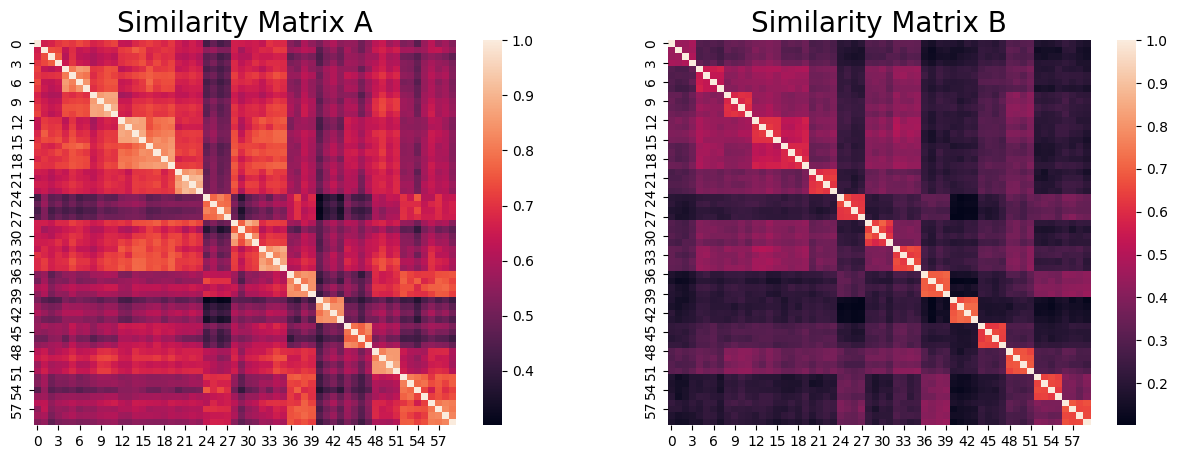

In [15]:
simA = 'output_aya/bracis/Llama-3.2-1B/clustered_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419164225/similarity_A_round1.npy'
simB = 'output_aya/bracis/Llama-3.2-1B/clustered_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419164225/similarity_B_round1.npy'

#subpplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Load the similarity matrices
similarity_A = np.load(simA)
similarity_B = np.load(simB)

sns.heatmap(similarity_A, ax=axes[0], cbar=True)
axes[0].set_title('Similarity Matrix A', fontsize=20)
sns.heatmap(similarity_B, ax=axes[1], cbar=True)
axes[1].set_title('Similarity Matrix B', fontsize=20)


In [16]:
def make_clusters(similarity_matrix, n_clusters, round, save_dendrogram=True, path=None):
    """Generate cluster labels using hierarchical clustering"""
    pdist = spc.distance.pdist(similarity_matrix)
    linkage = spc.linkage(pdist, method='ward')
    min_link = linkage[0][2]
    max_link = linkage[-1][2]

    th = max_link
    for i in np.linspace(min_link, max_link, 5000):
        le = len(pd.Series(spc.fcluster(linkage, i, 'distance')).unique())
        if le == n_clusters:
            th = i

    idx = spc.fcluster(linkage, th, 'distance')
    return idx

In [17]:
def compute_silhouette(similarity_matrix, cluster_labels):
    """Compute silhouette score correctly using a similarity matrix"""
    # Convert similarity to distance
    distance_matrix = 1 - similarity_matrix
    
    # Ensure diagonal is 0 (distance to self)
    np.fill_diagonal(distance_matrix, 0)
    
    # For silhouette score with precomputed distances, be sure we have at least 2 clusters
    if len(np.unique(cluster_labels)) < 2:
        return -1  # Invalid silhouette for single cluster
    
    try:
        return silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        return -1

def compute_within_cluster_distance(similarity_matrix, cluster_labels):
    """Compute within-cluster distance (for elbow method)"""
    # Convert similarity to distance
    distance_matrix = 1 - similarity_matrix
    
    wcd = 0
    n_valid_clusters = 0
    
    for cluster_id in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_indices) > 1:  # Need at least 2 points
            cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
            # Calculate average pairwise distance within this cluster
            avg_distance = np.sum(cluster_distances) / (len(cluster_indices) * (len(cluster_indices) - 1))
            wcd += avg_distance
            n_valid_clusters += 1
    
    # Return average within-cluster distance
    return wcd / n_valid_clusters if n_valid_clusters > 0 else 0

def compute_gap_statistic(similarity_matrix, cluster_labels, n_bootstraps=20):
    """Compute gap statistic for clustering evaluation"""
    # Convert similarity to distance
    distance_matrix = 1 - similarity_matrix
    
    # Get number of clusters
    k = len(np.unique(cluster_labels))
    
    # Calculate within-cluster sum of squares for original data
    wk_observed = 0
    for cluster_id in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_indices) > 1:  # Need at least 2 points to compute dispersion
            cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
            wk_observed += np.sum(cluster_distances) / (2 * len(cluster_indices))
    
    # Generate reference distributions and calculate gap statistic
    wks_reference = []
    
    for _ in range(n_bootstraps):
        # Generate uniform random data reference distribution
        # Instead of permuting distance matrix, we'll create a new random clustering
        random_labels = np.random.choice(k, size=len(cluster_labels))
        
        # Calculate within-cluster sum of squares for reference data
        wk_reference = 0
        for cluster_id in range(k):
            cluster_indices = np.where(random_labels == cluster_id)[0]
            if len(cluster_indices) > 1:  # Need at least 2 points
                cluster_distances = distance_matrix[np.ix_(cluster_indices, cluster_indices)]
                wk_reference += np.sum(cluster_distances) / (2 * len(cluster_indices))
        
        wks_reference.append(wk_reference)
    
    # Calculate gap statistic
    log_wk = np.log(wk_observed) if wk_observed > 0 else 0
    log_wks_ref = np.mean([np.log(wk) if wk > 0 else 0 for wk in wks_reference])
    
    # Gap statistic is expected reference - observed
    gap = log_wks_ref - log_wk
    
    return gap

In [18]:
def evaluate_clusters(similarity_matrix, min_clusters=2, max_clusters=10):
    """Evaluate clusters for different numbers of clusters"""
    n_clusters_range = list(range(min_clusters, max_clusters + 1))
    silhouette_scores = []
    within_cluster_distances = []
    gap_statistics = []
    
    for n_clusters in n_clusters_range:
        print(f"Evaluating {n_clusters} clusters...")
        
        # Generate cluster labels
        cluster_labels = make_clusters(similarity_matrix, n_clusters, round=0, save_dendrogram=False)
        
        # Compute metrics
        sil_score = compute_silhouette(similarity_matrix, cluster_labels)
        within_dist = compute_within_cluster_distance(similarity_matrix, cluster_labels)
        gap_stat = compute_gap_statistic(similarity_matrix, cluster_labels)
        
        # Store results
        silhouette_scores.append(sil_score)
        within_cluster_distances.append(within_dist)
        gap_statistics.append(gap_stat)
        
        print(f"  Silhouette: {sil_score:.4f}, Within-cluster distance: {within_dist:.4f}, Gap statistic: {gap_stat:.4f}")
    
    return n_clusters_range, silhouette_scores, within_cluster_distances, gap_statistics

In [19]:
def plot_metrics(n_clusters_range, silhouette_scores, within_cluster_distances, gap_statistics):
    """Plot the metrics for different numbers of clusters"""
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    # Plot silhouette scores (higher is better)
    axs[0].plot(n_clusters_range, silhouette_scores, 'o-', color='blue')
    axs[0].set_xlabel('Number of clusters')
    axs[0].set_ylabel('Silhouette Score')
    axs[0].set_title('Silhouette Score vs Number of Clusters')
    axs[0].grid(True)
    best_sil = n_clusters_range[np.argmax(silhouette_scores)]
    axs[0].axvline(x=best_sil, color='r', linestyle='--', 
                  label=f'Best value: {best_sil}')
    axs[0].legend()
    
    # Plot within-cluster distances (lower is better - looking for elbow)
    axs[1].plot(n_clusters_range, within_cluster_distances, 'o-', color='green')
    axs[1].set_xlabel('Number of clusters')
    axs[1].set_ylabel('Within-cluster distance')
    axs[1].set_title('Elbow Method: Within-cluster distance vs Number of Clusters')
    axs[1].grid(True)
    
    # Find elbow point using second derivative
    diffs = np.diff(within_cluster_distances, 2)
    elbow_idx = np.argmax(diffs) + 2 if len(diffs) > 0 else 0
    if elbow_idx < len(n_clusters_range):
        elbow_point = n_clusters_range[elbow_idx]
        axs[1].axvline(x=elbow_point, color='r', linestyle='--',
                      label=f'Elbow point: {elbow_point}')
        axs[1].legend()
    
    # Plot gap statistics (higher is better)
    axs[2].plot(n_clusters_range, gap_statistics, 'o-', color='red')
    axs[2].set_xlabel('Number of clusters')
    axs[2].set_ylabel('Gap Statistic')
    axs[2].set_title('Gap Statistic vs Number of Clusters')
    axs[2].grid(True)
    best_gap = n_clusters_range[np.argmax(gap_statistics)]
    axs[2].axvline(x=best_gap, color='r', linestyle='--',
                  label=f'Best value: {best_gap}')
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

In [20]:
# Evaluate clusters for different numbers of clusters
print("\nEvaluating clusters for different numbers of clusters...")
n_clusters_range, silhouette_scores, within_cluster_distances, gap_statistics = evaluate_clusters(
    similarity_A, min_clusters=2, max_clusters=9)

# Plot results
print("\nPlotting results...")
plot_metrics(n_clusters_range, silhouette_scores, within_cluster_distances, gap_statistics)

# Recommend optimal number of clusters
sil_opt = n_clusters_range[np.argmax(silhouette_scores)]

# Find elbow point
diffs = np.diff(within_cluster_distances, 2)
elbow_idx = np.argmax(diffs) + 2 if len(diffs) > 0 else 0
elbow_opt = n_clusters_range[elbow_idx] if elbow_idx < len(n_clusters_range) else "Not clear"

gap_opt = n_clusters_range[np.argmax(gap_statistics)]

print("\nOptimal number of clusters based on different metrics:")
print(f"Silhouette Score: {sil_opt}")
print(f"Elbow Method: {elbow_opt}")
print(f"Gap Statistic: {gap_opt}")


Evaluating clusters for different numbers of clusters...
Evaluating 2 clusters...


NameError: name 'spc' is not defined

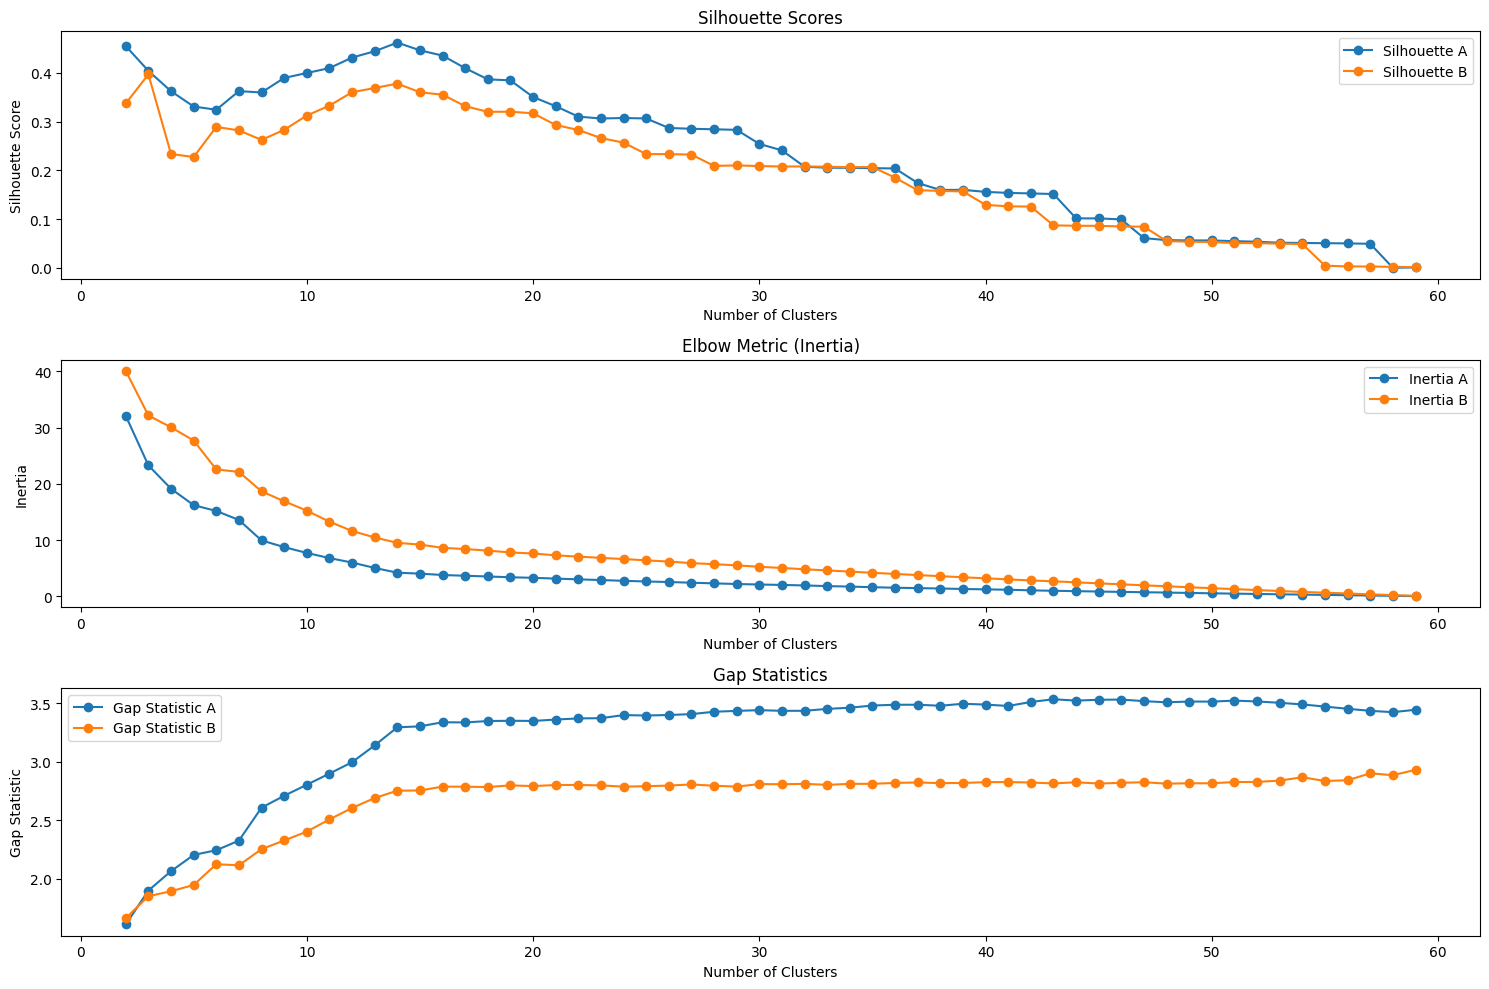

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import numpy as np

# Initialize lists to store metrics
silhouette_scores_A = []
silhouette_scores_B = []
inertia_A = []
inertia_B = []
gap_stats_A = []
gap_stats_B = []

# Function to calculate gap statistic
def calculate_gap_statistic(data, n_clusters, n_refs=60):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    ref_inertia = []
    for _ in range(n_refs):
        random_data = np.random.uniform(data.min(), data.max(), data.shape)
        ref_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(random_data)
        ref_inertia.append(ref_kmeans.inertia_)
    gap = np.log(np.mean(ref_inertia)) - np.log(kmeans.inertia_)
    return gap

# Calculate metrics for each number of clusters
for n_clusters in range(2, 60):
    kmeans_A = KMeans(n_clusters=n_clusters, random_state=42).fit(similarity_A)
    kmeans_B = KMeans(n_clusters=n_clusters, random_state=42).fit(similarity_B)

    # Silhouette scores
    silhouette_scores_A.append(silhouette_score(similarity_A, kmeans_A.labels_))
    silhouette_scores_B.append(silhouette_score(similarity_B, kmeans_B.labels_))

    # Inertia (Elbow metric)
    inertia_A.append(kmeans_A.inertia_)
    inertia_B.append(kmeans_B.inertia_)

    # Gap statistics
    gap_stats_A.append(calculate_gap_statistic(similarity_A, n_clusters))
    gap_stats_B.append(calculate_gap_statistic(similarity_B, n_clusters))

# Plotting
plt.figure(figsize=(15, 10))

# Silhouette scores
plt.subplot(3, 1, 1)
plt.plot(range(2, 60), silhouette_scores_A, label='Silhouette A', marker='o')
plt.plot(range(2, 60), silhouette_scores_B, label='Silhouette B', marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()

# Elbow metric (Inertia)
plt.subplot(3, 1, 2)
plt.plot(range(2, 60), inertia_A, label='Inertia A', marker='o')
plt.plot(range(2, 60), inertia_B, label='Inertia B', marker='o')
plt.title('Elbow Metric (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()

# Gap statistics
plt.subplot(3, 1, 3)
plt.plot(range(2, 60), gap_stats_A, label='Gap Statistic A', marker='o')
plt.plot(range(2, 60), gap_stats_B, label='Gap Statistic B', marker='o')
plt.title('Gap Statistics')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Statistic')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
np.argmax(gap_stats_A), np.argmax(gap_stats_B)

(np.int64(41), np.int64(57))

                      English     Dutch   Turkish  Portuguese   Spanish  \
FedAvg               0.215349  0.202730  0.107804    0.218150  0.246293   
Pre-Trained          0.101326  0.067096  0.053889    0.068530  0.052465   
Cluster 0            0.280446  0.000000  0.000000    0.000000  0.000000   
Cluster 1            0.000000  0.000000  0.126602    0.000000  0.000000   
Cluster 2            0.000000  0.256739  0.000000    0.000000  0.000000   
Cluster 3            0.000000  0.000000  0.000000    0.232165  0.000000   
Cluster 4            0.000000  0.000000  0.000000    0.000000  0.251212   
Fully Distributed 0  0.276470  0.000000  0.000000    0.000000  0.000000   
Fully Distributed 1  0.000000  0.219421  0.000000    0.000000  0.000000   
Fully Distributed 2  0.000000  0.000000  0.130216    0.000000  0.000000   
Fully Distributed 3  0.000000  0.000000  0.000000    0.220924  0.000000   
Fully Distributed 4  0.000000  0.000000  0.000000    0.000000  0.224558   

                        

<Figure size 800x600 with 0 Axes>

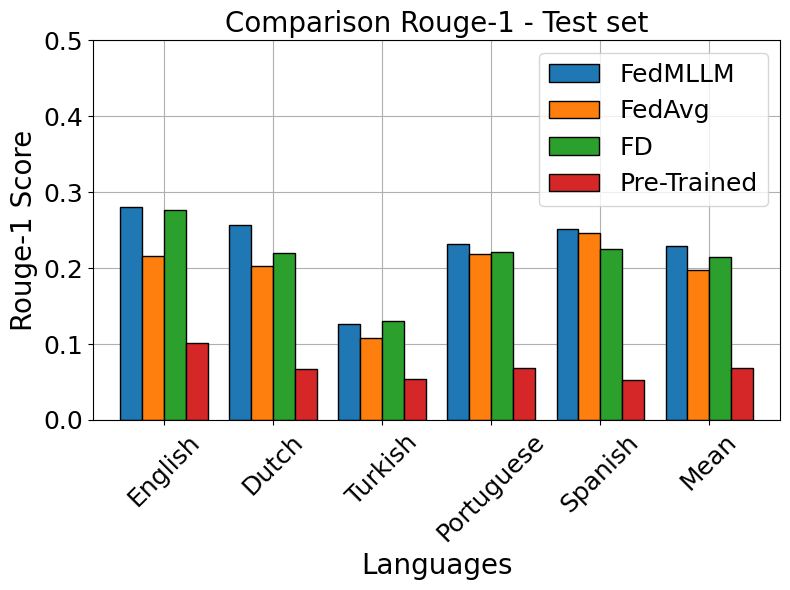

In [ ]:
import os, json, glob
import pandas as pd

# Define the solution names (rows)

clusters = [0, 1, 2, 3, 4]

labels = (
    ['FedAvg'] +
    ['Pre-Trained']+
    [f'Cluster {c}' for c in clusters] +
    [f'Fully Distributed {i}' for i in range(5)] 
)
round = 50

tasks = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']
model_name = 'Llama-3.2-1B'

path_pretrained = f'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/checkpoint-0'
path_fedavg = f'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/cluster_0_checkpoint-{round}'

# Create an empty DataFrame with rows = solution names and columns = tasks
results_table = pd.DataFrame(index=labels, columns=tasks)

# Define groups for fully distributed & fedDPA
groups_fully_dist = [[0,1], [2,3], [4,5], [6,7], [8,9]]
rk = 'rouge1'  # or 'rouge2', 'rougeL', etc.
rk_key = rk  # will use 'rouge1' from variable rk

for task in tasks:
    row_vals = []

    # FedAvg
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-{round}_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    row_vals.append(fedavg['rouge'][rk_key])

    # Pre-trained
    pretrained_results_path = path_pretrained + f'/checkpoint-0_{model_name}_{task}/results.json'
    with open(pretrained_results_path, 'r') as f:
        pretrained = json.load(f)
    row_vals.append(pretrained['rouge'][rk_key])
    
    # Clustered
    for cluster in clusters:
        try:
            path_clustered = f'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606'
            path_clustered_round_temp = path_clustered + f'/cluster_{cluster}_checkpoint-{round}'
            clustered_results_path = path_clustered_round_temp + f'/cluster_{cluster}_checkpoint-{round}_{model_name}_{task}/results.json'
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            row_vals.append(clustered['rouge'][rk_key])
        except FileNotFoundError:
            row_vals.append(0)
    
    
    # Fully Distributed (average each 5 clients group)
    for group_clients in groups_fully_dist:
        try:
            total = 0
            for client in group_clients:
                path_fd = f'output_aya/bracis/Llama-3.2-1B/FD_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072756/cluster_{client}_checkpoint-{round}'
                fd_results_path = path_fd + f'/cluster_{client}_checkpoint-{round}_{model_name}_{task}/results.json'
                with open(fd_results_path, 'r') as f:
                    fd = json.load(f)
                total += fd['rouge'][rk_key]
            row_vals.append(total / 2)
        except FileNotFoundError:
            row_vals.append(0)
    
    results_table[task] = row_vals

results_table['solution'] = ['FedAvg',
                            'Pre-Trained',
                            'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM',
                            'FD', 'FD', 'FD', 'FD', 'FD'
                            ]

# Print the table (you may also use .to_markdown() for a nicer display)
print(results_table)

# Sort the bars by Clustered, FedAvg, FD, Pre-Trained
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8,  6))

# Group by solution and take the max value for each solution
bar_table = results_table.groupby('solution').max()
bar_table['Mean'] = bar_table.mean(axis=1)

# Reorder the rows to match the desired order
bar_table = bar_table.loc[['FedMLLM', 'FedAvg', 'FD', 'Pre-Trained']]

# Transpose for plotting
bar_table = bar_table.T

# Plot the barplot with custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for bars
# Plot bars with different hatch styles
bars = bar_table.plot(kind='bar', ax=ax, color=colors, width=0.8, edgecolor='black')
plt.ylim(0, 0.5)

# Increase font sizes
ax.legend(fontsize=18)  # Increase legend font size
ax.tick_params(axis='both', which='major', labelsize=18)  # Increase tick font size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)  # Increase x-axis label font size
ax.set_ylabel(ax.get_ylabel(), fontsize=18)  # Increase y-axis label font size

plt.xlabel('Languages', fontsize=20)
plt.ylabel('Rouge-1 Score', fontsize=20)

# Rotate x ticks
plt.xticks(rotation=45)

# Add title to the plot
plt.title("Comparison Rouge-1 - Test set", fontsize=20)
ax.set_axisbelow(True)
ax.grid(True)


plt.tight_layout()
plt.savefig('figs/rouge1_1B.pdf', dpi=900)

plt.show()


                      English     Dutch   Turkish  Portuguese   Spanish  \
FedAvg               0.246707  0.226527  0.122311    0.229887  0.275474   
Pre-Trained          0.101326  0.067096  0.053889    0.068530  0.052465   
Cluster 0            0.310320  0.000000  0.000000    0.000000  0.000000   
Cluster 1            0.000000  0.000000  0.157822    0.000000  0.000000   
Cluster 2            0.000000  0.267127  0.000000    0.000000  0.000000   
Cluster 3            0.000000  0.000000  0.000000    0.000000  0.310746   
Cluster 4            0.000000  0.000000  0.000000    0.250460  0.000000   
Fully Distributed 0  0.276470  0.000000  0.000000    0.000000  0.000000   
Fully Distributed 1  0.000000  0.219421  0.000000    0.000000  0.000000   
Fully Distributed 2  0.000000  0.000000  0.130216    0.000000  0.000000   
Fully Distributed 3  0.000000  0.000000  0.000000    0.220924  0.000000   
Fully Distributed 4  0.000000  0.000000  0.000000    0.000000  0.224558   

                        

<Figure size 800x600 with 0 Axes>

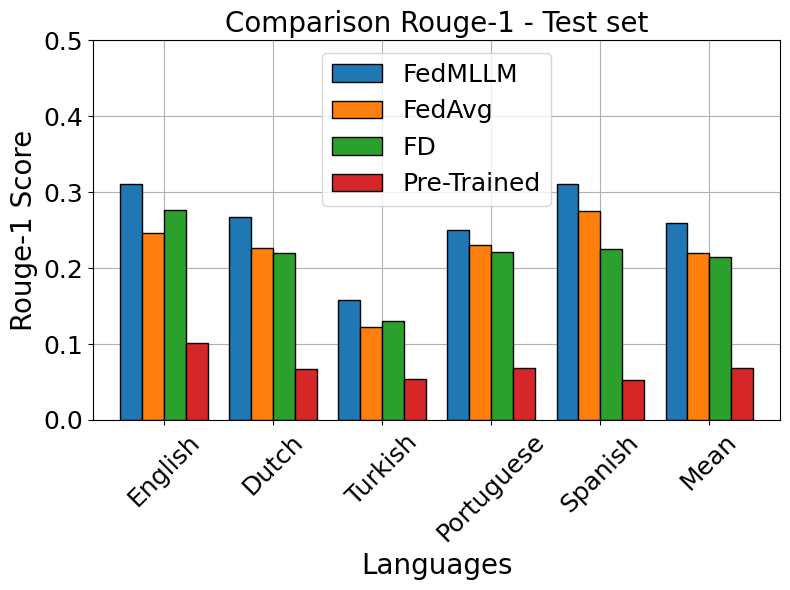

In [ ]:
import os, json, glob
import pandas as pd

# Define the solution names (rows)

clusters = [0, 1, 2, 3, 4]

labels = (
    ['FedAvg'] +
    ['Pre-Trained']+
    [f'Cluster {c}' for c in clusters] +
    [f'Fully Distributed {i}' for i in range(5)] 
)
round = 50

tasks = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']
model_name = 'Llama-3.2-1B'

path_pretrained = f'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/checkpoint-0'
path_fedavg = f'output_aya/bracis/Llama-3.2-1B/fedavg_lora32_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r32a64_20250425132103/cluster_0_checkpoint-{100}'

# Create an empty DataFrame with rows = solution names and columns = tasks
results_table = pd.DataFrame(index=labels, columns=tasks)

# Define groups for fully distributed & fedDPA
groups_fully_dist = [[0,1], [2,3], [4,5], [6,7], [8,9]]
rk = 'rouge1'  # or 'rouge2', 'rougeL', etc.
rk_key = rk  # will use 'rouge1' from variable rk

for task in tasks:
    row_vals = []

    # FedAvg
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-{100}_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    row_vals.append(fedavg['rouge'][rk_key])

    # Pre-trained
    pretrained_results_path = path_pretrained + f'/checkpoint-0_{model_name}_{task}/results.json'
    with open(pretrained_results_path, 'r') as f:
        pretrained = json.load(f)
    row_vals.append(pretrained['rouge'][rk_key])
    
    # Clustered
    for cluster in clusters:
        try:
            path_clustered = f'output_aya/bracis/Llama-3.2-1B/clustered_lora32_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r32a64_20250425132001'
            path_clustered_round_temp = path_clustered + f'/cluster_{cluster}_checkpoint-{100}'
            clustered_results_path = path_clustered_round_temp + f'/cluster_{cluster}_checkpoint-{100}_{model_name}_{task}/results.json'
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            row_vals.append(clustered['rouge'][rk_key])
        except FileNotFoundError:
            row_vals.append(0)
    
    
    # Fully Distributed (average each 5 clients group)
    for group_clients in groups_fully_dist:
        try:
            total = 0
            for client in group_clients:
                path_fd = f'output_aya/bracis/Llama-3.2-1B/FD_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072756/cluster_{client}_checkpoint-{round}'
                fd_results_path = path_fd + f'/cluster_{client}_checkpoint-{round}_{model_name}_{task}/results.json'
                with open(fd_results_path, 'r') as f:
                    fd = json.load(f)
                total += fd['rouge'][rk_key]
            row_vals.append(total / 2)
        except FileNotFoundError:
            row_vals.append(0)
    
    results_table[task] = row_vals

results_table['solution'] = ['FedAvg',
                            'Pre-Trained',
                            'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM',
                            'FD', 'FD', 'FD', 'FD', 'FD'
                            ]

# Print the table (you may also use .to_markdown() for a nicer display)
print(results_table)

# Sort the bars by Clustered, FedAvg, FD, Pre-Trained
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8,  6))

# Group by solution and take the max value for each solution
bar_table = results_table.groupby('solution').max()
bar_table['Mean'] = bar_table.mean(axis=1)

# Reorder the rows to match the desired order
bar_table = bar_table.loc[['FedMLLM', 'FedAvg', 'FD', 'Pre-Trained']]

# Transpose for plotting
bar_table = bar_table.T

# Plot the barplot with custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for bars
# Plot bars with different hatch styles
bars = bar_table.plot(kind='bar', ax=ax, color=colors, width=0.8, edgecolor='black')
plt.ylim(0, 0.5)

# Increase font sizes
ax.legend(fontsize=18)  # Increase legend font size
ax.tick_params(axis='both', which='major', labelsize=18)  # Increase tick font size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)  # Increase x-axis label font size
ax.set_ylabel(ax.get_ylabel(), fontsize=18)  # Increase y-axis label font size

plt.xlabel('Languages', fontsize=20)
plt.ylabel('Rouge-1 Score', fontsize=20)

# Rotate x ticks
plt.xticks(rotation=45)

# Add title to the plot
plt.title("Comparison Rouge-1 - Test set", fontsize=20)
ax.set_axisbelow(True)
ax.grid(True)


plt.tight_layout()
plt.savefig('figs/rouge1_1B.pdf', dpi=900)

plt.show()


                      English     Dutch   Turkish  Portuguese   Spanish  \
FedAvg               0.296075  0.271766  0.130037    0.290368  0.328076   
Pre-Trained          0.108637  0.042978  0.033287    0.067950  0.061346   
Cluster 0            0.310819  0.000000  0.000000    0.000000  0.000000   
Cluster 1            0.000000  0.000000  0.160403    0.000000  0.000000   
Cluster 2            0.000000  0.282815  0.000000    0.000000  0.000000   
Cluster 3            0.000000  0.000000  0.000000    0.273403  0.000000   
Cluster 4            0.000000  0.000000  0.000000    0.000000  0.343244   
Fully Distributed 0  0.293082  0.000000  0.000000    0.000000  0.000000   
Fully Distributed 1  0.000000  0.244485  0.000000    0.000000  0.000000   
Fully Distributed 2  0.000000  0.000000  0.163630    0.000000  0.000000   
Fully Distributed 3  0.000000  0.000000  0.000000    0.291810  0.000000   
Fully Distributed 4  0.000000  0.000000  0.000000    0.000000  0.320148   

                        

<Figure size 800x600 with 0 Axes>

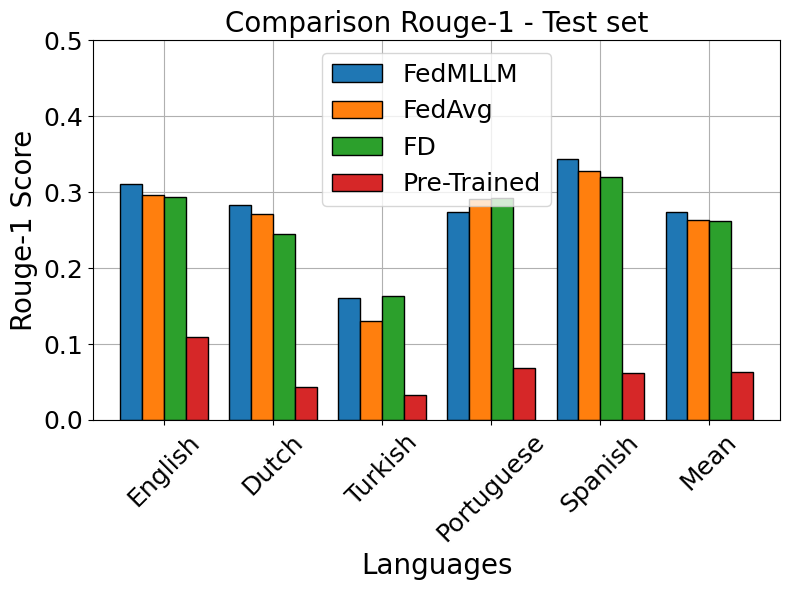

In [ ]:
import os, json, glob
import pandas as pd

# Define the solution names (rows)

clusters = [0, 1, 2, 3, 4]

labels = (
    ['FedAvg'] +
    ['Pre-Trained']+
    [f'Cluster {c}' for c in clusters] +
    [f'Fully Distributed {i}' for i in range(5)] 
)
round = 50

tasks = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']
model_name = 'Llama-3.2-3B'


path_pretrained = f'output_aya/bracis/Llama-3.2-3B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418184753/checkpoint-0'
path_fedavg = f'output_aya/bracis/Llama-3.2-3B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418184753/cluster_0_checkpoint-{round}'

# Create an empty DataFrame with rows = solution names and columns = tasks
results_table = pd.DataFrame(index=labels, columns=tasks)

# Define groups for fully distributed & fedDPA
groups_fully_dist = [[0,1], [2,3], [4,5], [6,7], [8,9]]
rk = 'rouge1'  # or 'rouge2', 'rougeL', etc.
rk_key = rk  # will use 'rouge1' from variable rk

for task in tasks:
    row_vals = []

    # FedAvg
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-{round}_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    row_vals.append(fedavg['rouge'][rk_key])

    # Pre-trained
    pretrained_results_path = path_pretrained + f'/checkpoint-0_{model_name}_{task}/results.json'
    with open(pretrained_results_path, 'r') as f:
        pretrained = json.load(f)
    row_vals.append(pretrained['rouge'][rk_key])
    
    # Clustered
    for cluster in clusters:
        path_clustered = f'output_aya/bracis/Llama-3.2-3B/clustered_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250420191606'
        path_clustered_round_temp = path_clustered + f'/cluster_{cluster}_checkpoint-{round}'
        clustered_results_path = path_clustered_round_temp + f'/cluster_{cluster}_checkpoint-{round}_{model_name}_{task}/results.json'
        try:
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            row_vals.append(clustered['rouge'][rk_key])
        except:
            row_vals.append(0)
    
    
    # Fully Distributed (average each 5 clients group)
    for group_clients in groups_fully_dist:

        try:
            total = 0
            for client in group_clients:
                path_fd = f'output_aya/bracis/Llama-3.2-3B/FD_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418184234/cluster_{client}_checkpoint-{round}'
                fd_results_path = path_fd + f'/cluster_{client}_checkpoint-{round}_{model_name}_{task}/results.json'
                with open(fd_results_path, 'r') as f:
                    fd = json.load(f)
                total += fd['rouge'][rk_key]
            row_vals.append(total / 2)
        except:
            row_vals.append(0)
    
    results_table[task] = row_vals

results_table['solution'] = ['FedAvg',
                            'Pre-Trained',
                            'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM',
                            'FD', 'FD', 'FD', 'FD', 'FD'
                            ]

# Print the table (you may also use .to_markdown() for a nicer display)
print(results_table)

# Sort the bars by Clustered, FedAvg, FD, Pre-Trained
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8,  6))

# Group by solution and take the max value for each solution
bar_table = results_table.groupby('solution').max()
bar_table['Mean'] = bar_table.mean(axis=1)

# Reorder the rows to match the desired order
bar_table = bar_table.loc[['FedMLLM', 'FedAvg', 'FD', 'Pre-Trained']]

# Transpose for plotting
bar_table = bar_table.T

# Plot the barplot with custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for bars
# Plot bars with different hatch styles
bars = bar_table.plot(kind='bar', ax=ax, color=colors, width=0.8, edgecolor='black')
plt.ylim(0, 0.5)

# Increase font sizes
ax.legend(fontsize=18)  # Increase legend font size
ax.tick_params(axis='both', which='major', labelsize=18)  # Increase tick font size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)  # Increase x-axis label font size
ax.set_ylabel(ax.get_ylabel(), fontsize=18)  # Increase y-axis label font size

plt.xlabel('Languages', fontsize=20)
plt.ylabel('Rouge-1 Score', fontsize=20)

# Rotate x ticks
plt.xticks(rotation=45)

# Add title to the plot
plt.title("Comparison Rouge-1 - Test set", fontsize=20)
ax.set_axisbelow(True)
ax.grid(True)

plt.tight_layout()
plt.savefig('figs/rouge1_3B.pdf', dpi=900)

plt.show()


              English     Dutch   Turkish  Portuguese   Spanish  Filipino  \
solution                                                                    
FD           0.268618  0.209577  0.147683    0.224322  0.263027  0.268463   
FedAvg       0.165552  0.161725  0.095795    0.151513  0.180524  0.084429   
FedMLLM      0.294943  0.237577  0.137646    0.249470  0.265078  0.280379   
Pre-Trained  0.078606  0.054180  0.043657    0.056125  0.051385  0.079846   

              Bengali  Standard Malay  Lithuanian     Tamil      Zulu  \
solution                                                                
FD           0.088456        0.242309    0.087220  0.032983  0.048391   
FedAvg       0.081037        0.157278    0.085159  0.038798  0.043490   
FedMLLM      0.086203        0.269125    0.116871  0.033440  0.041954   
Pre-Trained  0.041348        0.033990    0.023694  0.024786  0.032571   

                Irish    Nepali  Malayalam    Telugu  
solution                                   

<Figure size 800x600 with 0 Axes>

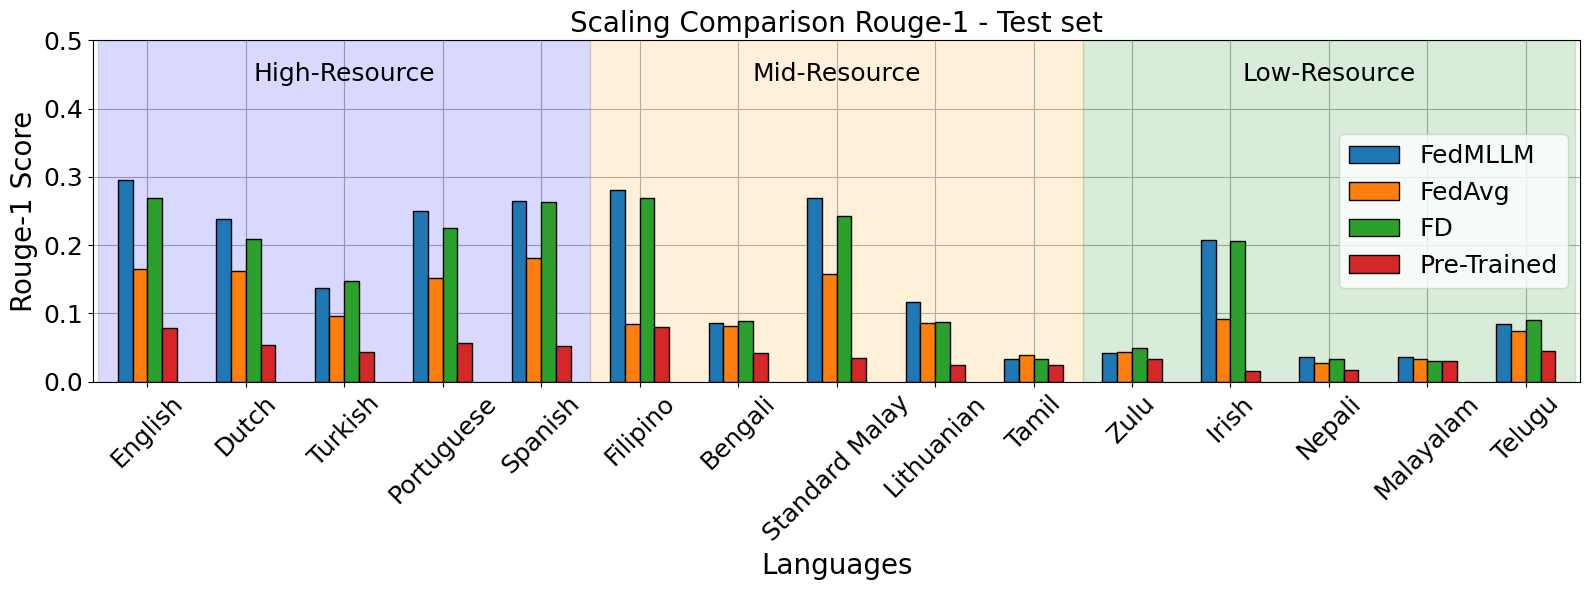

In [ ]:
import os, json, glob
import pandas as pd

# Define the solution names (rows)

clusters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

labels = (
    ['FedAvg'] +
    ['Pre-Trained']+
    [f'Cluster {c}' for c in clusters] +
    [f'Fully Distributed {i}' for i in range(15)]
)
round = 50

tasks = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish', 'Filipino', 'Bengali', 'Standard Malay', 'Lithuanian', 'Tamil', 'Zulu', 'Irish', 'Nepali', 'Malayalam', 'Telugu']
model_name = 'Llama-3.2-1B'


path_pretrained = f'/home/gabriel.talasso/FT_LLM_FL/output_aya/bracis/Llama-3.2-1B/fedavg_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419195712/checkpoint-0'
path_fedavg = f'/home/gabriel.talasso/FT_LLM_FL/output_aya/bracis/Llama-3.2-1B/fedavg_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419195712/cluster_0_checkpoint-{round}'

# Create an empty DataFrame with rows = solution names and columns = tasks
results_table = pd.DataFrame(index=labels, columns=tasks)

# Define groups for fully distributed & fedDPA
groups_fully_dist = [[0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15], [16,17,18,19], 
                      [20,21,22,23], [24,25,26,27], [28,29,30,31], [32,33,34,35], [36,37,38,39],
                      [40,41,42,43], [44,45,46,47], [48,49, 50,51], [52,53,54,55], [56,57,58,59]]
rk = 'rouge1'  # or 'rouge2', 'rougeL', etc.
rk_key = rk  # will use 'rouge1' from variable rk

for task in tasks:
    row_vals = []

    # FedAvg
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-{round}_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    row_vals.append(fedavg['rouge'][rk_key])

    # Pre-trained
    try:
        pretrained_results_path = path_pretrained + f'/checkpoint-0_{model_name}_{task}/results.json'
        with open(pretrained_results_path, 'r') as f:
            pretrained = json.load(f)
        row_vals.append(pretrained['rouge'][rk_key])
    except:
        row_vals.append(0)
    
    # Clustered
    for cluster in clusters:
        path_clustered = f'output_aya/bracis/Llama-3.2-1B/clustered_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419164225'
        path_clustered_round_temp = path_clustered + f'/cluster_{cluster}_checkpoint-{round}'
        clustered_results_path = path_clustered_round_temp + f'/cluster_{cluster}_checkpoint-{round}_{model_name}_{task}/results.json'
        try:
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            row_vals.append(clustered['rouge'][rk_key])
        except:
            row_vals.append(0)
    
    
    # Fully Distributed (average each 5 clients group)
    for group_clients in groups_fully_dist:

        try:
            total = 0
            for client in group_clients:
                path_fd = f'output_aya/bracis/Llama-3.2-1B/FD_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419230317/cluster_{client}_checkpoint-{round}'
                fd_results_path = path_fd + f'/cluster_{client}_checkpoint-{round}_{model_name}_{task}/results.json'
                with open(fd_results_path, 'r') as f:
                    fd = json.load(f)
                total += fd['rouge'][rk_key]
            row_vals.append(total / 4)
        except:
            row_vals.append(0)
    
    results_table[task] = row_vals

results_table['solution'] = ['FedAvg',
                            'Pre-Trained',
                            'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM',
                            'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM',
                            'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM',
                            'FD', 'FD', 'FD', 'FD', 'FD', 
                            'FD', 'FD', 'FD', 'FD', 'FD',
                            'FD', 'FD', 'FD', 'FD', 'FD',
                            ]

# Print the table (you may also use .to_markdown() for a nicer display)

# Sort the bars by Clustered, FedAvg, FD, Pre-Trained
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(16,  6))

# Group by solution and take the max value for each solution
bar_table = results_table.groupby('solution').max()
#bar_table['Mean'] = bar_table.mean(axis=1)
print(bar_table)

# Reorder the rows to match the desired order
bar_table = bar_table.loc[['FedMLLM', 'FedAvg', 'FD', 'Pre-Trained']]#, 'FD', 'Pre-Trained']]

# Transpose for plotting
bar_table = bar_table.T

ax.axvspan(-0.5, 4.5, alpha = 0.15, color='blue')
ax.axvspan(4.5, 9.5, alpha = 0.15, color='orange')
ax.axvspan(9.5, 14.5, alpha = 0.15, color='green')

ax.text(2, 0.45, "High-Resource", fontsize=18,  ha='center', va='center')
ax.text(7, 0.45, "Mid-Resource", fontsize=18,  ha='center', va='center')
ax.text(12, 0.45, "Low-Resource", fontsize=18, ha='center', va='center')

# Plot the barplot with custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for bars
# Plot bars with different hatch styles
bars = bar_table.plot(kind='bar', ax=ax, color=colors, width=0.6, edgecolor='black')
plt.ylim(0, 0.5)

# Increase font sizes
ax.legend(fontsize=18)  # Increase legend font size
ax.tick_params(axis='both', which='major', labelsize=18)  # Increase t font size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)  # Increase x-axis label font size
ax.set_ylabel(ax.get_ylabel(), fontsize=18)  # Increase y-axis label font size


plt.xlabel('Languages', fontsize=20)
plt.ylabel('Rouge-1 Score', fontsize=20)

# Rotate x ticks
plt.xticks(rotation=45) 

# Add title to the plot
plt.title("Scaling Comparison Rouge-1 - Test set", fontsize=20)
ax.set_axisbelow(True)
ax.grid(True)

plt.tight_layout()
plt.savefig('figs/rouge1_1B_scaling.pdf', dpi=900)

plt.show()

In [ ]:
path_ds = 'output_aya/bracis/Llama-3.2-1B/fedavg_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419195712/cluster_0_checkpoint-50/cluster_0_checkpoint-50_Llama-3.2-1B_English/responses/'

import datasets

#load arrow dataset from disk
datasets.load_from_disk(path_ds)['model_responses']

['Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is a Guillotine? \n\n### Response: ',
 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the function of a neuron. \n\n### Response:  Neurons are the basic units of the nervous system. They are responsible for transmitting signals from one part of the brain or body to another. Neurons are made up of a cell body, dendrites, and an axon. The cell body is the part of the neuron that contains the nucleus and other organelles. The dendrites are the branches of the neuron that receive signals from other neurons or from the body. The axon is the part of the neuron that carries the signal to the next neuron or to the body. Neurons are responsible for transmitting signals from one part of the brain or body to another. They are also responsible for processing information and sen

In [ ]:
import evaluate
from collections import Counter

import re
from rouge_score import tokenize

# Redefine patterns to include Bengali
tokenize.NON_ALPHANUM_PATTERN = r"[^\u0980-\u09FFa-z0-9]+"
tokenize.NON_ALPHANUM_RE = re.compile(tokenize.NON_ALPHANUM_PATTERN)
tokenize.VALID_TOKEN_PATTERN = r"^[\u0980-\u09FFa-z0-9]+$"
tokenize.VALID_TOKEN_RE = re.compile(tokenize.VALID_TOKEN_PATTERN)


def rouge_1_tokenized(predicted_tokens, reference_tokens):
    pred_counter = Counter(predicted_tokens)
    ref_counter = Counter(reference_tokens)

    # Calculate overlap
    overlap = sum((pred_counter & ref_counter).values())

    # Precision, Recall, F1
    precision = overlap / max(1, sum(pred_counter.values()))
    recall = overlap / max(1, sum(ref_counter.values()))
    f1 = 2 * precision * recall / max(1e-8, precision + recall)

    return {
        "rouge-1": {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }
    }

def calcule_rogue1(model_responses, dataset):
    metric = evaluate.load("rouge", use_aggregator=False)
    references = [dataset[i]['targets'] for i in range(len(dataset))]
    #predictions  = [response.split("### Response: ")[-1] for response in model_responses]
    predictions = [dataset[i]['model_responses'].split("### Response: ")[-1] for i in range(len(dataset))]
    scores = metric.compute(predictions=predictions, references=references, )#tokenizer=lambda x: list(x))
    return scores, predictions, references

def calcule_rouge_in_tokens(model_responses, dataset, tokenizer):
    metric = evaluate.load("rouge")
    references = [dataset[i]['targets'] for i in range(len(dataset))]
    #predictions  = [response.split("### Response: ")[-1] for response in model_responses]
    predictions = [dataset[i]['model_responses'].split("### Response: ")[-1] for i in range(len(dataset))]
    predictions = [tokenizer.encode(prediction, truncation=True, max_length=512) for prediction in predictions]
    references = [tokenizer.encode(reference, truncation=True, max_length=512) for reference in references]

    scores = []
    for pred, ref in zip(predictions, references):
        score = rouge_1_tokenized(pred, ref)
        scores.append(score['rouge-1']['f1'])
    return scores, predictions, references

from transformers import AutoTokenizer
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
# Load the dataset
dataset = datasets.load_from_disk(path_ds)

# Calculate the rouge scores
rouge_scores, predictions, references = calcule_rogue1(datasets.load_from_disk(path_ds)['model_responses'], dataset)
#rouge_scores_in_tokens, predictions_in_tokens, references_in_tokens = calcule_rouge_in_tokens(datasets.load_from_disk(path_ds)['model_responses'], dataset, tokenizer)

In [ ]:
rouge_scores

{'rouge1': np.float64(0.16519241323716993),
 'rouge2': np.float64(0.06400864592430722),
 'rougeL': np.float64(0.13365898342054405),
 'rougeLsum': np.float64(0.1422190942995395)}

In [ ]:
np.mean(rouge_scores_in_tokens)

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [ ]:
rouge_scores['rouge1']

np.float64(0.0)

                 English     Dutch   Turkish  Portuguese   Spanish  \
FedAvg          0.215349  0.202730  0.107804    0.218150  0.246293   
Pre-Trained     0.101326  0.067096  0.053889    0.068530  0.052465   
Cluster 0       0.280446  0.000000  0.000000    0.000000  0.000000   
Cluster 1       0.000000  0.000000  0.126602    0.000000  0.000000   
Cluster 2       0.000000  0.256739  0.000000    0.000000  0.000000   
Cluster 3       0.000000  0.000000  0.000000    0.232165  0.000000   
Cluster 4       0.000000  0.000000  0.000000    0.000000  0.251212   
Cluster (+1) 0  0.252677  0.000000  0.000000    0.000000  0.000000   
Cluster (+1) 1  0.279641  0.000000  0.107004    0.000000  0.000000   
Cluster (+1) 2  0.000000  0.138655  0.121654    0.000000  0.000000   
Cluster (+1) 3  0.000000  0.248488  0.000000    0.208616  0.219981   
Cluster (+1) 4  0.000000  0.000000  0.000000    0.225240  0.000000   
Cluster (-1) 0  0.000000  0.000000  0.000000    0.000000  0.244286   
Cluster (-1) 1  0.28

<Figure size 800x600 with 0 Axes>

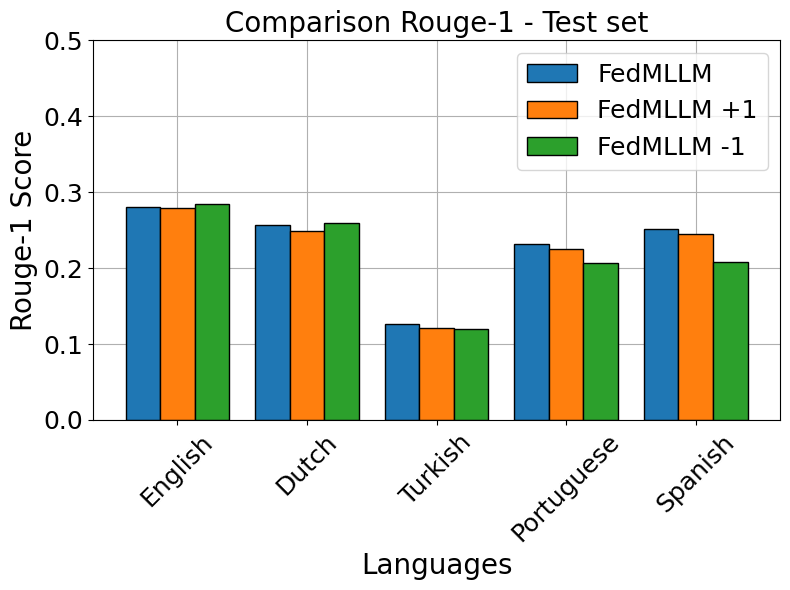

In [60]:
import os, json, glob
import pandas as pd

# Define the solution names (rows)

clusters = [0, 1, 2, 3, 4]
clusters1 = [0, 1, 2, 3, 4, 5]
clusters2 = [0, 1, 2, 3]

labels = (
    ['FedAvg'] +
    ['Pre-Trained']+
    [f'Cluster {c}' for c in clusters] +
    [f'Cluster (+1) {c}' for c in clusters] +
    [f'Cluster (-1) {c}' for c in clusters]  +  
    [f'FD {i}' for i in range(5)] 
)
round = 50
path_pretrained = f'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/checkpoint-0'
path_fedavg = f'output_aya/bracis/Llama-3.2-1B/fedavg_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072714/cluster_0_checkpoint-{round}'


model_name = 'Llama-3.2-1B'
tasks = ['English', 'Dutch', 'Turkish', 'Portuguese', 'Spanish']

# Create an empty DataFrame with rows = solution names and columns = tasks
results_table = pd.DataFrame(index=labels, columns=tasks)

# Define groups for fully distributed & fedDPA
groups_fully_dist = [[0,1], [2,3], [4,5], [6,7], [8,9]]
rk = 'rouge1'  # or 'rouge2', 'rougeL', etc.
rk_key = rk  # will use 'rouge1' from variable rk

for task in tasks:
    row_vals = []

    # FedAvg
    fedavg_results_path = path_fedavg + f'/cluster_0_checkpoint-{round}_{model_name}_{task}/results.json'
    with open(fedavg_results_path, 'r') as f:
        fedavg = json.load(f)
    row_vals.append(fedavg['rouge'][rk_key])

    # Pre-trained
    pretrained_results_path = path_pretrained + f'/checkpoint-0_{model_name}_{task}/results.json'
    with open(pretrained_results_path, 'r') as f:
        pretrained = json.load(f)
    row_vals.append(pretrained['rouge'][rk_key])

    # FedAvg
    for cluster in clusters:
        path_clustered = f'output_aya/bracis/Llama-3.2-1B/clustered_round1_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072606'
        path_clustered_round_temp = path_clustered + f'/cluster_{cluster}_checkpoint-{50}'
        clustered_results_path = path_clustered_round_temp + f'/cluster_{cluster}_checkpoint-{50}_{model_name}_{task}/results.json'
        try:
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            row_vals.append(clustered['rouge'][rk_key])
        except:
            row_vals.append(0)
    
    # Clustered
    for cluster in clusters1:
        path_clustered = f'output_aya/bracis/Llama-3.2-1B/clustered_mais_um_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250422144727'
        path_clustered_round_temp = path_clustered + f'/cluster_{cluster}_checkpoint-{50}'
        clustered_results_path = path_clustered_round_temp + f'/cluster_{cluster}_checkpoint-{50}_{model_name}_{task}/results.json'
        try:
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            row_vals.append(clustered['rouge'][rk_key])
        except:
            row_vals.append(0)
    
    
    # Fully Distributed (average each 5 clients group)
    for cluster in clusters2:
        path_clustered = f'output_aya/bracis/Llama-3.2-1B/clustered_menos_um_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250422144813'
        path_clustered_round_temp = path_clustered + f'/cluster_{cluster}_checkpoint-{50}'
        clustered_results_path = path_clustered_round_temp + f'/cluster_{cluster}_checkpoint-{50}_{model_name}_{task}/results.json'
        try:
            with open(clustered_results_path, 'r') as f:
                clustered = json.load(f)
            row_vals.append(clustered['rouge'][rk_key])
        except:
            row_vals.append(0)

    for group_clients in groups_fully_dist:
        try:
            total = 0
            for client in group_clients:
                path_fd = f'output_aya/bracis/Llama-3.2-1B/FD_aya_dataset_clustered_c10s10_i10_b16a1_l1024_r8a16_20250418072756/cluster_{client}_checkpoint-{round}'
                fd_results_path = path_fd + f'/cluster_{client}_checkpoint-{round}_{model_name}_{task}/results.json'
                with open(fd_results_path, 'r') as f:
                    fd = json.load(f)
                total += fd['rouge'][rk_key]
            row_vals.append(total / 2)
        except FileNotFoundError:
            row_vals.append(0)
    
    results_table[task] = row_vals

results_table['solution'] = [
                            'FedAvg',
                            'Pre-Trained',
                            'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM', 'FedMLLM',
                            'FedMLLM +1', 'FedMLLM +1', 'FedMLLM +1', 'FedMLLM +1', 'FedMLLM +1', 'FedMLLM +1',
                            'FedMLLM -1', 'FedMLLM -1', 'FedMLLM -1', 'FedMLLM -1',
                            'FD', 'FD', 'FD', 'FD', 'FD',
                            ]

# Print the table (you may also use .to_markdown() for a nicer display)
print(results_table)

# Sort the bars by Clustered, FedAvg, FD, Pre-Trained
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(figsize=(8,  6))

# Group by solution and take the max value for each solution
bar_table = results_table.groupby('solution').max()

# Reorder the rows to match the desired order
bar_table = bar_table.loc[['FedMLLM', 'FedMLLM +1', 'FedMLLM -1']]#, 'FedAvg', 'FD', 'Pre-Trained']]

# Transpose for plotting
bar_table = bar_table.T

# Plot the barplot with custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Custom colors for bars
# Plot bars with different hatch styles
bars = bar_table.plot(kind='bar', ax=ax, color=colors, width=0.8, edgecolor='black')
plt.ylim(0, 0.5)

# Increase font sizes
ax.legend(fontsize=18)  # Increase legend font size
ax.tick_params(axis='both', which='major', labelsize=18)  # Increase tick font size
ax.set_xlabel(ax.get_xlabel(), fontsize=18)  # Increase x-axis label font size
ax.set_ylabel(ax.get_ylabel(), fontsize=18)  # Increase y-axis label font size

plt.xlabel('Languages', fontsize=20)
plt.ylabel('Rouge-1 Score', fontsize=20)

# Rotate x ticks
plt.xticks(rotation=45)

# Add title to the plot
plt.title("Comparison Rouge-1 - Test set", fontsize=20)
ax.set_axisbelow(True)
ax.grid(True)

plt.tight_layout()
plt.savefig('figs/rouge1_num_clusters.pdf', dpi=900)

plt.show()


In [22]:
from safetensors.torch import load_file
import torch
import sys
import os
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as spc
from safetensors.torch import load_file

def get_adapter(path, client, round = 50, layer = -1):


    adapter_path_client = path + f'/clients_adapters/checkpoint-{round}_client{client}/adapter_model.safetensors'
    adapter_path_global = path+ f'/checkpoint-{round-1}/adapter_model.safetensors'

    # Load the adapter weights from the checkpoint using safetensors
    adapter_state_dict = load_file(adapter_path_client, device='cpu')
    adapter_global = load_file(adapter_path_global, device='cpu')
    #adapter_global = torch.load(adapter_path_global, map_location='cpu', weights_only=False)


    # Access the adapter weights (as tensors)
    adapter_weights_A = [param for name, param in adapter_state_dict.items() if 'lora_A' in name]
    adapter_weights_B = [param for name, param in adapter_state_dict.items() if 'lora_B' in name]

    adapter_weights_A_global = [param for name, param in adapter_global.items() if 'lora_A' in name]
    adapter_weights_B_global = [param for name, param in adapter_global.items() if 'lora_B' in name]

    # Subtract the global adapter weights from the client adapter weights

    if layer == 'all':
        adapter_weights_A = [adapter_weights_A[i] - adapter_weights_A_global[i] for i in range(len(adapter_weights_A))]
        adapter_weights_B = [adapter_weights_B[i] - adapter_weights_B_global[i] for i in range(len(adapter_weights_B))]

        adapter_weights_A = torch.cat([adapter_weights_A[i].flatten() for i in range(len(adapter_weights_A))])
        adapter_weights_B = torch.cat([adapter_weights_B[i].flatten() for i in range(len(adapter_weights_B))])

    else:
        adapter_weights_A = adapter_weights_A[layer] - adapter_weights_A_global[layer]
        adapter_weights_B = adapter_weights_B[layer] - adapter_weights_B_global[layer]

    #adapter_weights_A = adapter_weights_A[layer]
    #adapter_weights_B = adapter_weights_B[layer]

    #flatten
    adapter_weights_A = adapter_weights_A.flatten()
    adapter_weights_B = adapter_weights_B.flatten()

    return adapter_weights_A,  adapter_weights_B

In [62]:
n_clients = 60
path = 'output_aya/bracis/Llama-3.2-1B/clustered_scaling_multi_language_clusters_clustered_c60s60_i10_b16a1_l1024_r8a16_20250419164225'
layer = 'all'
round = 1

import time

start = time.time()

similarity_A = np.zeros((n_clients,n_clients))
similarity_B = np.zeros((n_clients,n_clients))
similarity_AB = np.zeros((n_clients,n_clients))

for c1 in list(range(n_clients)):
    #print(f'Calculating similarity for {c1}')
    adapter_weights_A_c1, adapter_weights_B_c1 = get_adapter(path, client = c1, round = round, layer = layer) 
    adapter_weights_A_c1 = adapter_weights_A_c1.cpu()
    adapter_weights_B_c1 = adapter_weights_B_c1.cpu()

    adapter_weights_AB_c1 = torch.cat((adapter_weights_A_c1, adapter_weights_B_c1), dim=0)

    for c2 in list(range(n_clients)):
        adapter_weights_A_c2, adapter_weights_B_c2 = get_adapter(path, client = c2, round = round, layer = layer)
        adapter_weights_A_c2 = adapter_weights_A_c2.cpu()
        adapter_weights_B_c2 = adapter_weights_B_c2.cpu()
        adapter_weights_AB_c2 = torch.cat((adapter_weights_A_c2, adapter_weights_B_c2), dim=0)

        
        #cosine similarity
        cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
        cos_A = cos(adapter_weights_A_c1, adapter_weights_A_c2)
        cos_B = cos(adapter_weights_B_c1, adapter_weights_B_c2)
        cos_AB = cos(adapter_weights_AB_c1, adapter_weights_AB_c2)
        similarity_A[c1][c2] = cos_A
        similarity_B[c1][c2] = cos_B
        similarity_AB[c1][c2] = cos_AB
        
print(f'Time taken: {time.time() - start} seconds')
#sns.heatmap(similarity_A, cbar=True, ax=ax[0])
#sns.heatmap(similarity_B, cbar=True, ax=ax[1])

Time taken: 26.12299132347107 seconds


In [24]:
def make_clusters(similarity_matrix, n_clusters, round, save_dendrogram = True, path = None):

    pdist = spc.distance.pdist(similarity_matrix)
    linkage = spc.linkage(pdist, method='ward')
    min_link = linkage[0][2]
    max_link = linkage[-1][2]


    th = max_link
    for i in np.linspace(min_link,max_link, 5000):
        le = len(pd.Series(spc.fcluster(linkage, i, 'distance')).unique())
        if le == n_clusters:
            th = i

    idx = spc.fcluster(linkage, th, 'distance')
    return idx

In [26]:
#corret clusters are grouped in 4
correct_clusteres = [list(range(0,4)),
                     list(range(4,8)),
                     list(range(8,12)),
                     list(range(12,16)),
                     list(range(16,20)),
                     list(range(20,24)),
                     list(range(24,28)),
                     list(range(28,32)),
                     list(range(32,36)),
                     list(range(36,40)),
                     list(range(40,44)),
                     list(range(44,48)),
                     list(range(48,52)),
                     list(range(52,56)),
                     list(range(56,60))]

In [ ]:
predicted_clusteres  = make_clusters(similarity_B, n_clusters = 15, round = 1, save_dendrogram = True, path = path)
predicted_clusteres

array([1, 1, 3, 3, 2, 2, 4, 4, 5, 5], dtype=int32)

In [27]:
correct = 0
for c in range(60):

    #get idx of clients with cluster c
    clients_with_c = np.where(predicted_clusteres == predicted_clusteres[c])[0]
    print(clients_with_c, correct_clusteres[c//4])
    if set(clients_with_c) == set(correct_clusteres[c//4]):
        print(f'Cluster {c} is correct')
        correct += 1

print(f'Correct clusters: {correct} out of {60}')

[0 1 2 3] [0, 1, 2, 3]
Cluster 0 is correct
[0 1 2 3] [0, 1, 2, 3]
Cluster 1 is correct
[0 1 2 3] [0, 1, 2, 3]
Cluster 2 is correct
[0 1 2 3] [0, 1, 2, 3]
Cluster 3 is correct
[4 5 6 7] [4, 5, 6, 7]
Cluster 4 is correct
[4 5 6 7] [4, 5, 6, 7]
Cluster 5 is correct
[4 5 6 7] [4, 5, 6, 7]
Cluster 6 is correct
[4 5 6 7] [4, 5, 6, 7]
Cluster 7 is correct
[ 8  9 10 11] [8, 9, 10, 11]
Cluster 8 is correct
[ 8  9 10 11] [8, 9, 10, 11]
Cluster 9 is correct
[ 8  9 10 11] [8, 9, 10, 11]
Cluster 10 is correct
[ 8  9 10 11] [8, 9, 10, 11]
Cluster 11 is correct
[12 13 14 15] [12, 13, 14, 15]
Cluster 12 is correct
[12 13 14 15] [12, 13, 14, 15]
Cluster 13 is correct
[12 13 14 15] [12, 13, 14, 15]
Cluster 14 is correct
[12 13 14 15] [12, 13, 14, 15]
Cluster 15 is correct
[16 17 18 19] [16, 17, 18, 19]
Cluster 16 is correct
[16 17 18 19] [16, 17, 18, 19]
Cluster 17 is correct
[16 17 18 19] [16, 17, 18, 19]
Cluster 18 is correct
[16 17 18 19] [16, 17, 18, 19]
Cluster 19 is correct
[20 21 22 23] [20, 21,

In [28]:
def calcule_separation_gap(similarity_matrix, cluster_labels):
    """Is the min similarity intra cluster minus the max similarity inter cluster"""

    min_similarities = []
    max_similarities = []
    separation_gap = []
    n_clusters = len(np.unique(cluster_labels))

    # Calculate the minimum similarity within each cluster
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id+1)[0]
        similarities = similarity_matrix[cluster_indices][:, cluster_indices]
        #print(similarities, cluster_indices)
        min_similarity = np.min(similarities[similarities != 1])
        min_similarities.append(min_similarity)

    # Calculate the maximum similarity between clusters
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id+1)[0]
        other_indices = np.where(cluster_labels != cluster_id+1)[0]
        similarities = similarity_matrix[cluster_indices][:, other_indices]
        max_similarity = np.max(similarities)
        max_similarities.append(max_similarity)
    
    #print('Min similarities:', min_similarities)
    #print('Max similarities:', max_similarities)
    
    # Calculate the separation gap
    for i in range(n_clusters):
        separation_gap.append(min_similarities[i] - max_similarities[i])


    return separation_gap

def bootstrap_gap(similarity_matrix, cluster_labels, n_iter = 5, n_clusters = [2,5,10,15]):
    """Bootstrap the separation gap"""

    bootstrap_separation_gaps = []
    bootstrap_separation_gaps_std = []
    bootstrap_separation_gaps_quantiles_005 = []
    bootstrap_separation_gaps_quantiles_095 = []
    for n_cluster in n_clusters:
        aux_results = []
        for i in range(n_iter):
            selected_clusters = np.random.choice(np.unique(cluster_labels), size = n_cluster, replace = False)
            #print('Selected clusters:', selected_clusters)
            selected_clients = []
            clusters_labels_new = []
            for cluster in selected_clusters:
                clients_with_c = np.where(cluster_labels == cluster)[0]
                selected_clients += list(clients_with_c)
                clusters_labels_new += [cluster] * len(clients_with_c)
            #print('Selected clients:', selected_clients)
            selected_sims = similarity_matrix[selected_clients][:, selected_clients]

            #map clusters labels to 1,2,3,4 Ex: [7,7,7,8,8,8] -> [1,1,1,2,2,2]
            clusters_labels_new = np.array(clusters_labels_new)
            clusters_labels_new = np.unique(clusters_labels_new, return_inverse=True)[1] + 1

            #
            separation_gap = calcule_separation_gap(selected_sims, clusters_labels_new)
            aux_results.append(np.mean(separation_gap))
        
        #print('Aux results:', aux_results)
        bootstrap_separation_gaps.append(np.mean(aux_results, axis = 0))
        bootstrap_separation_gaps_std.append(np.std(aux_results, axis = 0))
        
        #quantiles
        bootstrap_separation_gaps_quantiles_005.append(np.quantile(aux_results, 0.05, axis = 0))
        bootstrap_separation_gaps_quantiles_095.append(np.quantile(aux_results, 0.95, axis = 0))

    return bootstrap_separation_gaps, bootstrap_separation_gaps_std, bootstrap_separation_gaps_quantiles_005, bootstrap_separation_gaps_quantiles_095

In [ ]:
bootstrap_separation_gaps_A, bootstrap_separation_gaps_std_A, bootstrap_separation_gaps_quantiles_005_A, bootstrap_separation_gaps_quantiles_095_A  = bootstrap_gap(similarity_A, predicted_clusteres, n_iter = 1000, n_clusters = list(range(2, 16)))
bootstrap_separation_gaps_B, bootstrap_separation_gaps_std_B, bootstrap_separation_gaps_quantiles_005_B, bootstrap_separation_gaps_quantiles_095_B  = bootstrap_gap(similarity_B, predicted_clusteres, n_iter = 1000, n_clusters = list(range(2, 16)))
bootstrap_separation_gaps_AB, bootstrap_separation_gaps_std_AB, bootstrap_separation_gaps_quantiles_005_AB, bootstrap_separation_gaps_quantiles_095_AB  = bootstrap_gap(similarity_AB, predicted_clusteres, n_iter = 1000, n_clusters = list(range(2, 16)))

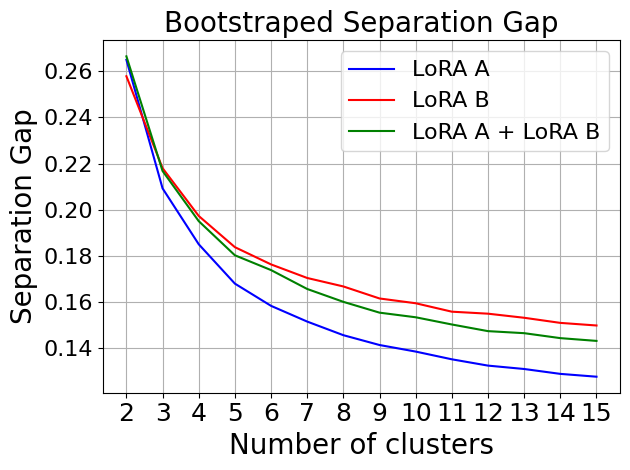

In [ ]:
#plot
import seaborn as sns
sns.lineplot(x = list(range(2, 16)), y = bootstrap_separation_gaps_A, label = 'LoRA A', color = 'blue')
sns.lineplot(x = list(range(2, 16)), y = bootstrap_separation_gaps_B, label = 'LoRA B', color = 'red')
sns.lineplot(x = list(range(2, 16)), y = bootstrap_separation_gaps_AB, label = 'LoRA A + LoRA B', color = 'green')

plt.title('Bootstraped Separation Gap', fontsize=20)
plt.xlabel('Number of clusters', fontsize=20)
plt.ylabel('Separation Gap', fontsize=20)
plt.xticks(list(range(2, 16)), fontsize=18)
plt.legend(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig('figs/bootstrap_separation_gap.pdf', dpi=900)

#plt.fill_between(list(range(2, 16)), bootstrap_separation_gaps_quantiles_005_A, bootstrap_separation_gaps_quantiles_095_A, alpha=0.2, color='blue')
#plt.fill_between(list(range(2, 16)), bootstrap_separation_gaps_quantiles_005_B, bootstrap_separation_gaps_quantiles_095_B, alpha=0.2, color='red')

In [102]:
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt

def calculate_silhouette_score(data, labels):

    # Check if we have at least 2 clusters and each cluster has more than 1 sample
    n_clusters = len(np.unique(labels))
    if n_clusters < 2:
        return 0
    
    try:
        score = silhouette_score(data, labels)
        return score
    except:
        # Handle cases where silhouette score calculation fails
        return 0

def find_optimal_clusters(data, min_clusters=2, max_clusters=15, random_state=42):

    silhouette_scores = []
    labels_list = []
    
    # Test different numbers of clusters
    for n_clusters in range(min_clusters, max_clusters + 1):
        cluster_labels = make_clusters(data, n_clusters, round = 1, save_dendrogram = False)
        score = calculate_silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)
        labels_list.append(cluster_labels)
    
    # Find the best number of clusters
    optimal_idx = np.argmax(silhouette_scores)
    optimal_n_clusters = min_clusters + optimal_idx
    
    return optimal_n_clusters, silhouette_scores, labels_list[optimal_idx]

def find_optimal_clusters_elbow(data, min_clusters=2, max_clusters=15):
    """Find the optimal number of clusters using the elbow method"""
    
    # Store the results for each number of clusters
    inertia_values = []
    
    # Try different numbers of clusters
    for n_clusters in range(min_clusters, max_clusters + 1):
        # Apply clustering
        cluster_labels = make_clusters(data, n_clusters, round=1, save_dendrogram=False)
        
        # Calculate the within-cluster sum of squared distances (inertia equivalent)
        inertia = 0
        for cluster_id in range(1, n_clusters + 1):  # Cluster labels start from 1
            cluster_indices = np.where(cluster_labels == cluster_id)[0]
            if len(cluster_indices) > 1:  # Need at least 2 points in a cluster
                # Extract the similarity submatrix for this cluster
                cluster_similarities = data[np.ix_(cluster_indices, cluster_indices)]
                
                # Convert similarities to distances (1 - similarity)
                cluster_distances = 1 - cluster_similarities
                
                # Calculate sum of squared distances within this cluster
                np.fill_diagonal(cluster_distances, 0)
                inertia += np.sum(cluster_distances**2) / (2 * len(cluster_indices))
        
        inertia_values.append(inertia)
    
    # Find the elbow point - where the rate of decrease sharply changes
    diffs = np.diff(inertia_values)
    diffs2 = np.diff(diffs)
    
    # The elbow point is where the second difference is maximum
    if len(diffs2) > 0:
        elbow_idx = np.argmax(diffs2) + 2
        optimal_n_clusters = min_clusters + elbow_idx
    else:
        # Default to the middle value if we can't find an elbow
        optimal_n_clusters = (min_clusters + max_clusters) // 2
    
    return optimal_n_clusters, inertia_values

def calcule_separation_gap(similarity_matrix, cluster_labels):
    """Is the min similarity intra cluster minus the max similarity inter cluster"""

    min_similarities = []
    max_similarities = []
    separation_gap = []
    n_clusters = len(np.unique(cluster_labels))
    #sns.heatmap(similarity_matrix, cbar=True)
    #plt.show()

    # Calculate the minimum similarity within each cluster
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id+1)[0]
        similarities = similarity_matrix[cluster_indices][:, cluster_indices]
        #sns.heatmap(similarities, cbar=True)
        #plt.show()
        min_similarity = np.min(similarities[similarities != 1])
        min_similarities.append(min_similarity)

    # Calculate the maximum similarity between clusters
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster_id+1)[0]
        other_indices = np.where(cluster_labels != cluster_id+1)[0]
        similarities = similarity_matrix[cluster_indices][:, other_indices]
        #sns.heatmap(similarities, cbar=True)
        #plt.show()
        max_similarity = np.max(similarities)
        max_similarities.append(max_similarity)
    
    print('Min similarities:', min_similarities)
    print('Max similarities:', max_similarities)
    
    # Calculate the separation gap
    for i in range(n_clusters):
        #if np.round(min_similarities[i], 2) != 1.0:

        separation_gap.append(min_similarities[i] - max_similarities[i])

    print('Separation gap:', separation_gap)
    print('Mean separation gap:', np.mean(separation_gap))
    return separation_gap


def calule_separation_gaps_n_clusters(similarity_matrix, min_clusters = 2, max_clusters = 15):

    separation_gaps = []
    separation_gaps_std = []
    separation_gap_max = []
    for n_clusters in range(min_clusters, max_clusters + 1):
        cluster_labels = make_clusters(similarity_matrix, n_clusters, round = 1, save_dendrogram = False)
        separation_gap = calcule_separation_gap(similarity_matrix, cluster_labels)
        separation_gaps.append(np.mean(separation_gap))
        separation_gaps_std.append(np.std(separation_gap))
        separation_gap_max.append(np.max(separation_gap))
        
    return separation_gaps, separation_gaps_std, separation_gap_max

def bootstrap_n_clusters(similarity_matrix, cluster_labels, n_clusters = [3,4,5], n_iter = 5):

    results = []
    for n_cluster in n_clusters:
        print('Number of clusters:', n_cluster)
        aux_results = []
        for i in range(n_iter):
            selected_clusters = np.random.choice(np.unique(cluster_labels), size = n_cluster, replace = False)
            #print('Selected clusters:', selected_clusters)
            selected_clients = []
            clusters_labels_new = []
            for cluster in selected_clusters:
                clients_with_c = np.where(cluster_labels == cluster)[0]
                selected_clients += list(clients_with_c)
                clusters_labels_new += [cluster] * len(clients_with_c)
            #print('Selected clients:', selected_clients)
            selected_sims = similarity_matrix[selected_clients][:, selected_clients]

            #map clusters labels to 1,2,3,4 Ex: [7,7,7,8,8,8] -> [1,1,1,2,2,2]
            clusters_labels_new = np.array(clusters_labels_new)
            clusters_labels_new = np.unique(clusters_labels_new, return_inverse=True)[1] + 1

            optimal_n_clusters, silhouette_scores, labels_list = find_optimal_clusters(selected_sims, min_clusters=2, max_clusters=len(clusters_labels_new))
            aux_results.append(optimal_n_clusters)
        
        results.append(np.median(aux_results))
        mode = np.bincount(aux_results).argmax()
        #second most common
        second_most_common = np.bincount(aux_results).argsort()[-2]
        print('Results:', np.median(aux_results), mode, second_most_common)
    return results

cluster_labels = predicted_clusteres
#bootstrap_n_clusters_A = bootstrap_n_clusters(similarity_A, cluster_labels, n_clusters = list(range(2, 15)), n_iter = 10)
#bootstrap_n_clusters_B = bootstrap_n_clusters(similarity_B, cluster_labels, n_clusters = list(range(2, 15)), n_iter = 10)

In [87]:
cluster_labels = make_clusters(similarity_B, n_clusters = 50, round = 1, save_dendrogram = False)
calcule_separation_gap(similarity_B, cluster_labels)

Min similarities: [np.float64(0.6004124879837036), np.float64(1.0000042915344238), np.float64(1.0000029802322388), np.float64(1.000003695487976), np.float64(1.0000033378601074), np.float64(0.601636528968811), np.float64(1.0000025033950806), np.float64(1.0000035762786865), np.float64(1.0000014305114746), np.float64(1.0000039339065552), np.float64(1.000003695487976), np.float64(1.0000020265579224), np.float64(1.0000041723251343), np.float64(1.0000022649765015), np.float64(1.0000026226043701), np.float64(1.000002384185791), np.float64(1.0000028610229492), np.float64(1.0000014305114746), np.float64(1.0000033378601074), np.float64(1.0000022649765015), np.float64(1.0000025033950806), np.float64(1.0000048875808716), np.float64(1.0000053644180298), np.float64(1.0000025033950806), np.float64(1.000001072883606), np.float64(1.0000028610229492), np.float64(1.0000026226043701), np.float64(1.0000009536743164), np.float64(0.5946216583251953), np.float64(1.0000014305114746), np.float64(1.0000041723251

[np.float64(0.29626378417015076),
 np.float64(0.4238671660423279),
 np.float64(0.4238658547401428),
 np.float64(0.4270268678665161),
 np.float64(0.44291162490844727),
 np.float64(0.017305731773376465),
 np.float64(0.415671706199646),
 np.float64(0.4175289273262024),
 np.float64(0.42148464918136597),
 np.float64(0.42148715257644653),
 np.float64(0.42413729429244995),
 np.float64(0.42247116565704346),
 np.float64(0.4563910961151123),
 np.float64(0.4563891887664795),
 np.float64(0.4611586928367615),
 np.float64(0.46804434061050415),
 np.float64(0.5062159597873688),
 np.float64(0.5062145292758942),
 np.float64(0.5152491331100464),
 np.float64(0.5198019444942474),
 np.float64(0.44080716371536255),
 np.float64(0.44080954790115356),
 np.float64(0.4447472095489502),
 np.float64(0.44603705406188965),
 np.float64(0.44521868228912354),
 np.float64(0.4452204704284668),
 np.float64(0.4709813594818115),
 np.float64(0.46366655826568604),
 np.float64(0.0280148983001709),
 np.float64(0.4333946704864502

In [ ]:
sep_gaps, sep_gap_std, sep_max, sep_min = calule_separation_gaps_n_clusters(similarity_B, min_clusters = 2, max_clusters = 25)

Min similarities: [np.float64(0.20020638406276703), np.float64(0.12921683490276337)]
Max similarities: [np.float64(0.29222652316093445), np.float64(0.29222652316093445)]
Separation gap: [np.float64(-0.09202013909816742), np.float64(-0.16300968825817108)]
Mean separation gap: -0.12751491367816925
Min similarities: [np.float64(0.20020638406276703), np.float64(0.6435999870300293), np.float64(0.2878805100917816)]
Max similarities: [np.float64(0.29222652316093445), np.float64(0.24871014058589935), np.float64(0.29222652316093445)]
Separation gap: [np.float64(-0.09202013909816742), np.float64(0.39488984644412994), np.float64(-0.004346013069152832)]
Mean separation gap: 0.0995078980922699
Min similarities: [np.float64(0.6004124879837036), np.float64(0.2565462291240692), np.float64(0.6435999870300293), np.float64(0.2878805100917816)]
Max similarities: [np.float64(0.30414870381355286), np.float64(0.30414870381355286), np.float64(0.24871014058589935), np.float64(0.29222652316093445)]
Separation g

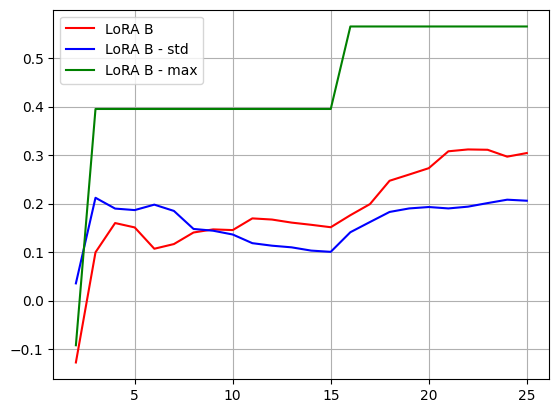

In [104]:
sns.lineplot(x = list(range(2, 26)), y = sep_gaps, label = 'LoRA B', color = 'red')
sns.lineplot(x = list(range(2, 26)), y = sep_gap_std, label = 'LoRA B - std', color = 'blue')
sns.lineplot(x = list(range(2, 26)), y = sep_max, label = 'LoRA B - max', color = 'Green')
plt.grid()

In [47]:
opt, sil_list, _ = find_optimal_clusters(similarity_B, min_clusters=2, max_clusters=60)
opt

np.int64(4)

In [48]:
opt_elbow, sil_list_elbow = find_optimal_clusters_elbow(similarity_B, min_clusters=2, max_clusters=30)
opt_elbow

np.int64(10)

<Axes: >

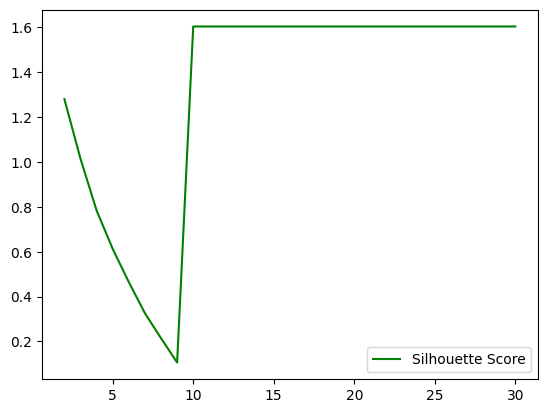

In [59]:
sns.lineplot(x = list(range(2, 31)), y = sil_list_elbow, label = 'Silhouette Score', color = 'green')